**cml1 - Immobilienrechner**

# Einfache lineare Regression und Residuenanalyse

Verwende ein einfaches lineares Modell zur Vorhersage von `price_cleaned` mit dem Attribut `Space extracted` oder `Floor_space_merged` (es gibt einige, wo beide fehlen (um die 800, können ignoriert werden).

Entwickle das Modell in einem Notebook. Untersuche dabei ob die Annahmen eines linearen Modells erfüllt sind mit geeigneten Darstellungen. Wie können Variablen-Transformationen verwendet werden, um die Modellvoraussetzungen besser zu erfüllen und das Modell zu verbessern?

Rapportiere und diskutiere die erreichte Genauigkeit der Vorhersage mit mehreren sinnvollen Metriken und auf unabhängigen Testdaten.

Wir haben im Notebook "datawrangling.ipynb" den Datensatz bereinigt und lesen dieser hier ein. Die Aufgabe dieses Notebooks ist es, ein einfaches lineares Modell zu erstellen, um Vorhersagen von `price_cleaned` mit dem Attribut `Space extracted` oder `Floor_space_merged` zu machen. In unserem Fall ist der Attribut `Living_area_unified`, da wir alle "Nutzfläche" Variablen zusammengefasst haben.

**Achtung:** Im Datawrangling Notebook haben wir `Space extracted` zu `Living_area_unified` zusammengefasst. Anstelle hier also wie in der Aufgabenstellung `Space extraced` zu wählen, arbeiten wir mit `Living_area_unified`.

## Daten laden und betrachten

In [1]:
# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import itertools

# Models
from sklearn.linear_model import LinearRegression

# Model selection
from sklearn.model_selection import train_test_split

# Imputer
from sklearn.impute import KNNImputer

# Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle

In [2]:
df = pd.read_csv('../../../data/immo_data_clean.csv', low_memory=False)
print("Anzahl der Zeilen: ", df.shape[0])
print("Anzahl der Spalten: ", df.shape[1])

Anzahl der Zeilen:  21466
Anzahl der Spalten:  57


Nun untersuchen wir die gefragten Variablen und machen uns Gedanken über die Modellvoraussetzungen.

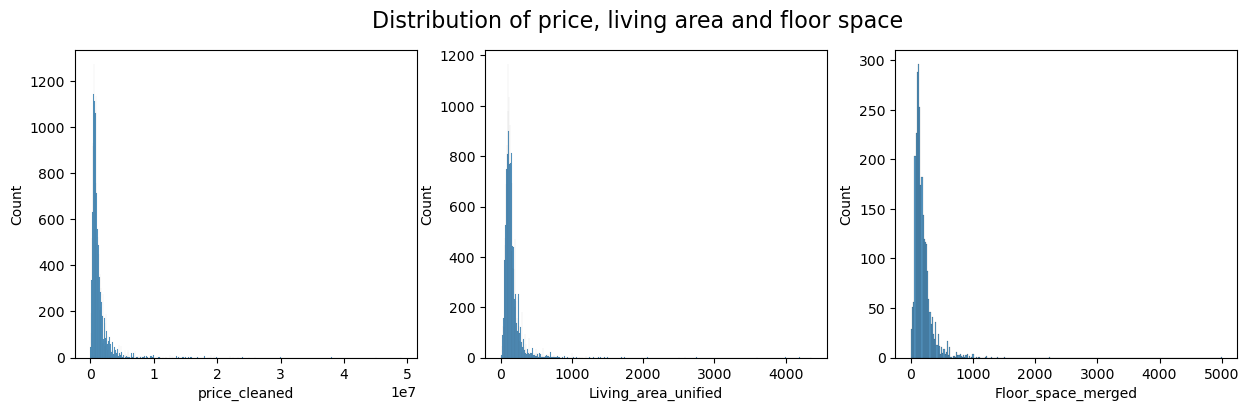

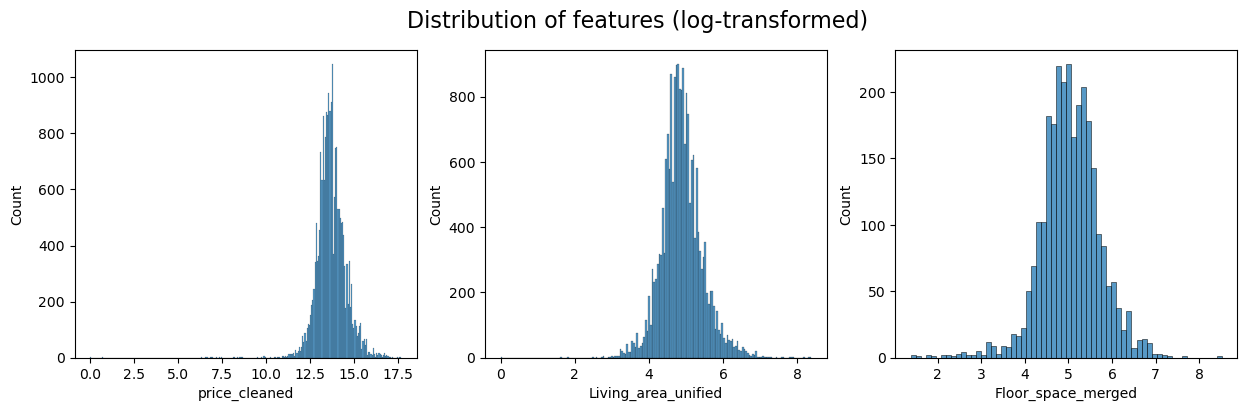

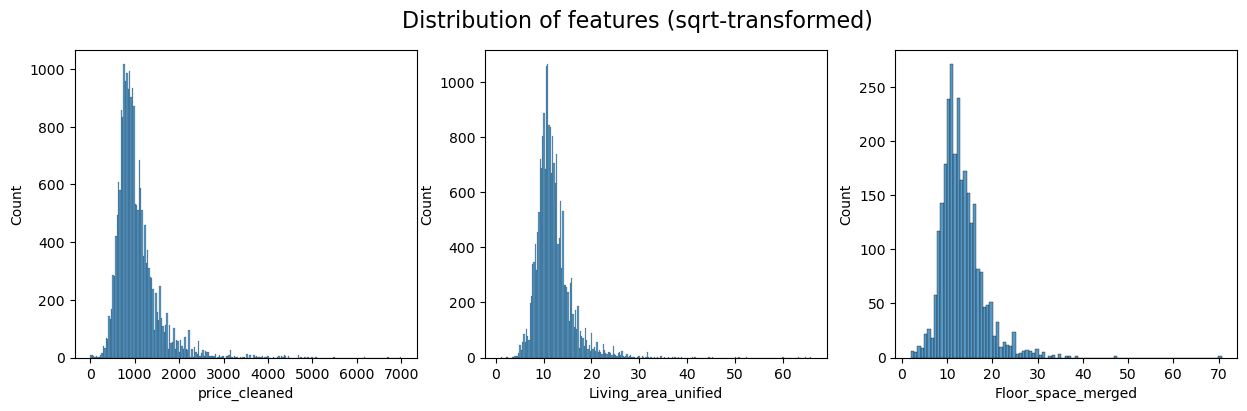

In [3]:
def plot_distributions(var1, var2, var3, title):
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(title, fontsize=16)
    sns.histplot(var1, ax=ax[0])
    sns.histplot(var2, ax=ax[1])
    sns.histplot(var3, ax=ax[2])
    plt.show()
    
plot_distributions(
    df['price_cleaned'], 
    df['Living_area_unified'], 
    df['Floor_space_merged'], 
    'Distribution of price, living area and floor space'
)

plot_distributions(
    np.log(df['price_cleaned']),
    np.log(df['Living_area_unified']),
    np.log(df['Floor_space_merged']),
    'Distribution of features (log-transformed)'
)

plot_distributions(
    np.sqrt(df['price_cleaned']),
    np.sqrt(df['Living_area_unified']),
    np.sqrt(df['Floor_space_merged']),
    'Distribution of features (sqrt-transformed)'
)

Anhand der Verteilungen ohne Transformationen, sehen wir das die Verteilungen nicht normalverteilt sind, sondern linksschief. Bei einer linearen Regression kann eine linksschiefe Verteilung problematisch sein, da sie oft die Normalverteilungsannahme der Residuen verletzt, was die Genauigkeit und Validität der Modellschätzungen beeinträchtigt. Solche Verteilungen können auch zu einem überproportionalen Einfluss von Ausreissern führen. Um diese Probleme zu beheben, werden häufig Transformationen der Daten eingesetzt, um eine symmetrischere Verteilung zu erreichen und die Modellannahmen zu erfüllen. 

Wenn wir also die transformierten Verteilungen anschauen, sehen wir genauere Normalverteilungen. Es sind aber trotzdem viele Ausreisser vorhanden.

Schauen wir nun die fehlenden Werte unserer Variablen an.

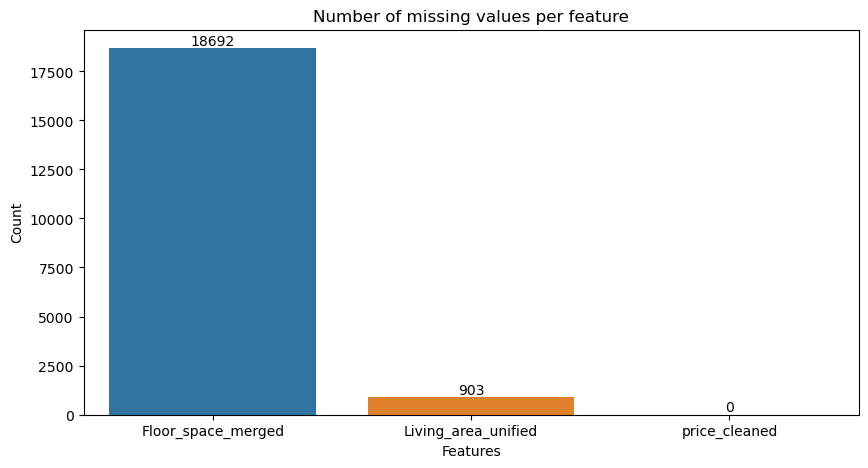

In [4]:
df_na = df[['price_cleaned', 'Living_area_unified', 'Floor_space_merged']].isnull().sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=df_na.index, y=df_na.values)
for i, v in enumerate(df_na.values):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.title('Number of missing values per feature')
plt.xlabel('Features')
plt.ylabel('Count')
plt.show()

Der Output von oben Zeigt uns: `Floor_space_merged` hat extrem viele fehlende Werte. Eine "einfache" lineare Regression würde hier nicht gut funktionieren.

In [5]:
# check where both columns are missing
df[(df['Living_area_unified'].isnull()) & (df['Floor_space_merged'].isnull())].shape

(711, 57)

Dieser Ouput von 711 Zeilen zeigt die in der Aufgabenstellung angekündigten ca. 800 Fehlenden Werte beider Features.

In [6]:
# drop rows where both columns are missing
df = df.dropna(subset=['Living_area_unified', 'Floor_space_merged'], how='all')
df[(df['Living_area_unified'].isnull()) & (df['Floor_space_merged'].isnull())].shape

(0, 57)

Wie in der Aufgabenstellung beschrieben werden diese 711 Zeilen nun für unsere Modelle ignoriert.

In [7]:
df_211 = df.copy()
df_212 = df.copy()
df_213 = df.copy()
df_214 = df.copy()

Wir haben nun folgende Optionen für die Modellierung:

- Wir verwenden nur `Living_area_unified` und rechnen unser Modell so - (2.1.1)

- Wir ersetzen fehlende `Floor_space_merged` values mit `Living_area_unified` - (2.1.2)

- Wir ersetzen fehlende `Living_area_unified` values mit `Floor_space_merged` - (2.1.3)

- Wir versuchen anhand der beiden Features ein neues Feature zu generieren das anstelle `Floor_space_merged` verwendet wird. - (2.1.4)

- Wir verwenden ein nicht lineares Modell, welches dann aber nicht mehr der Aufgabenstellung für 2.1 entspricht

## Lineare Regression mit `Living_area_unified`

In dieser Teilaufgabe (2.1.1) wird eine einfache lineare Regression mit `Living_area_unified` als Feature und `price_cleaned` als Zielvariable erstellt. Wir werden die Annahmen eines linearen Modells mit geeigneten Darstellungen untersuchen und Variablen-Transformationen verwenden, um die Modellvoraussetzungen eventuell besser zu erfüllen und das Modell zu verbessern.

In [8]:
# Subset dataset
df_211 = df_211[['Living_area_unified', 'price_cleaned']]

# Drop na values
df_211 = df_211.dropna(subset=['Living_area_unified'])

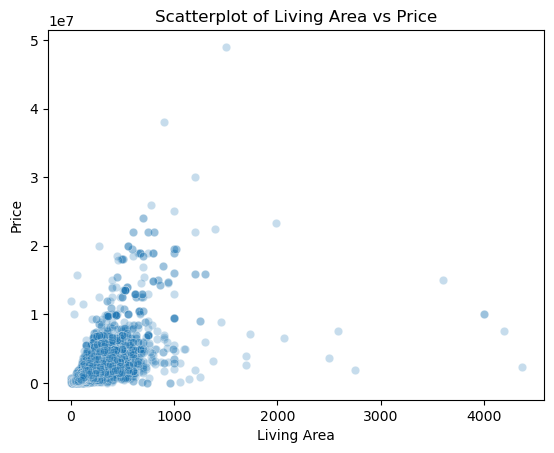

In [9]:
# Split dataset
X = df_211['Living_area_unified']
y = df_211['price_cleaned']

sns.scatterplot(data=df_211, x=X, y=y, alpha=0.25)
plt.title('Scatterplot of Living Area vs Price')
plt.ylabel('Price')
plt.xlabel('Living Area')
plt.show()

Anhand des Scatterplots sehen wir keine grosse Korrelaiton zwischen dem Preis und der Nutzfläche. Wir werden trotzdem eine lineare Regression durchführen und die Residuen analysieren.

Erstellen wir nun eine Funktion, bei der wir verschiedene Modelle erstellen können. Die Funktion wird folgendermassen gestaltet:

Eingabe:
1. $X$ (Feature-Daten)
2. $y$ (Zielvariable)
3. Eine Transformationsfunktion (optional), die auf $X$ angewendet wird, bevor die Regression durchgeführt wird.

Ausgabe:
- Ein Plot mit drei Subplots: "Actual vs Predicted Price", "Residuals" und "Residuals Histogram".
- Ein Print mit den Metriken: `R2`, `RMSE` und `MAE`

In [10]:
def perform_linear_regression(X, y, x_transformation_func=None, y_transformation_func=None, plot=True, title=""):
    """
    Performs a linear regression on the given data. 
    If provided, applies the given transformation functions to the data and plots the results.
    """

    # Apply transformation if provided
    if x_transformation_func:
        X = x_transformation_func(X)

    if y_transformation_func:
        y = y_transformation_func(y)
    
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train linear regression model
    lin_reg = LinearRegression()

    if len(X_train.shape) == 1:
        lin_reg.fit(X_train.values.reshape(-1, 1), y_train)
        y_pred = lin_reg.predict(X_test.values.reshape(-1, 1))
    else:
        lin_reg.fit(X_train, y_train)
        y_pred = lin_reg.predict(X_test)

    # Transform back to original scale
    if y_transformation_func and y_transformation_func.__name__ == 'log':
        y_pred = np.exp(y_pred)
        y_test = np.exp(y_test)
    elif y_transformation_func and y_transformation_func.__name__ == 'sqrt':
        y_pred = np.square(y_pred)
        y_test = np.square(y_test)
    elif y_transformation_func and y_transformation_func.__name__ == 'square':
        y_pred = np.sqrt(y_pred)
        y_test = np.sqrt(y_test)

    r2 = round(r2_score(y_test, y_pred),4)
    mse = mean_squared_error(y_test, y_pred)
    mse_sqrt = round(np.sqrt(mse),2)
    mae = round(np.mean(np.abs(y_test - y_pred)),2)

    if plot:
    
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        fig.suptitle(title, fontsize=16)
        
        # Actual vs Predicted plot
        sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha': 0.1}, ax=ax[0])
        ax[0].set_title('Actual vs Predicted')
        ax[0].set_xlabel('Actual Price')
        ax[0].set_ylabel('Predicted Price')

        # Residuals plot
        sns.residplot(x=y_test, y=y_pred, scatter_kws={'alpha': 0.1}, ax=ax[1])
        ax[1].set_title('Residuals')
        ax[1].set_xlabel('Actual Price')
        ax[1].set_ylabel('Residuals')

        # Histogram plot
        sns.histplot((y_test - y_pred), ax=ax[2])
        ax[2].set_title('Residuals Histogram')
        ax[2].set_xlabel('Residuals')
        ax[2].set_ylabel('Frequency')
        
        plt.show()

    else:
        print(title)

    print(f'R2: {r2:.4f} - RMSE: {mse_sqrt:.4f}, MAE: {mae:.4f}\n')

In [11]:
def train_linear_regression(X, y, x_transformation_func=None, y_transformation_func=None):
    """
    Trains a linear regression on the given data. 
    returns the model (used to store in a pickle file)
    """

    # Apply transformation if provided
    if x_transformation_func:
        X = x_transformation_func(X)

    if y_transformation_func:
        y = y_transformation_func(y)
    
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train linear regression model
    lin_reg = LinearRegression()

    if len(X_train.shape) == 1:
        lin_reg.fit(X_train.values.reshape(-1, 1), y_train)
        y_pred = lin_reg.predict(X_test.values.reshape(-1, 1))
    else:
        lin_reg.fit(X_train, y_train)
        y_pred = lin_reg.predict(X_test)
    return lin_reg

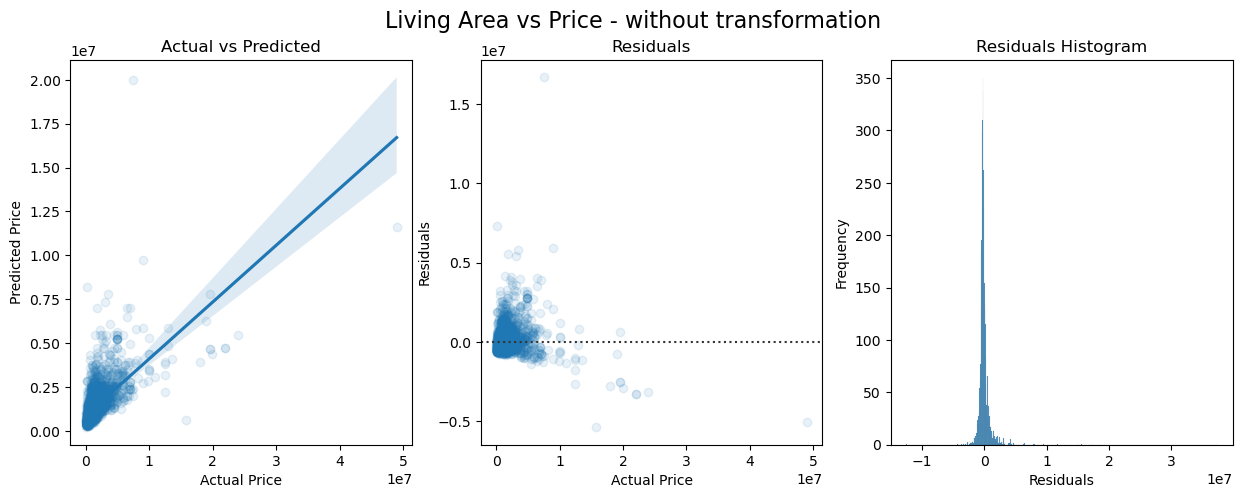

R2: 0.3932 - RMSE: 1339575.9200, MAE: 570184.6900



In [12]:
perform_linear_regression(X, y, None, None, True, "Living Area vs Price - without transformation")

Es ist gut zu sehen, dass das Modell die Immobilienpreise nicht gut vorhersagen kann.
- $R^2$ ist sehr klein: 39.32%.
- Die Residuen streuen sich meistens um den Erwartungswert 0, wir sehen aber sehr grosse Ausreisser.
- Die Residuen sind recht normalverteilt, aber es gibt auch hier grosse Ausreisser.

Um das Modell eventuell zu verbessern, werden wir folgende Variablen-Transformation machen:
- Log
- Quadrat
- Quadratwurzel

### Log-Transformation (Teilaufgabe 2.1.1)

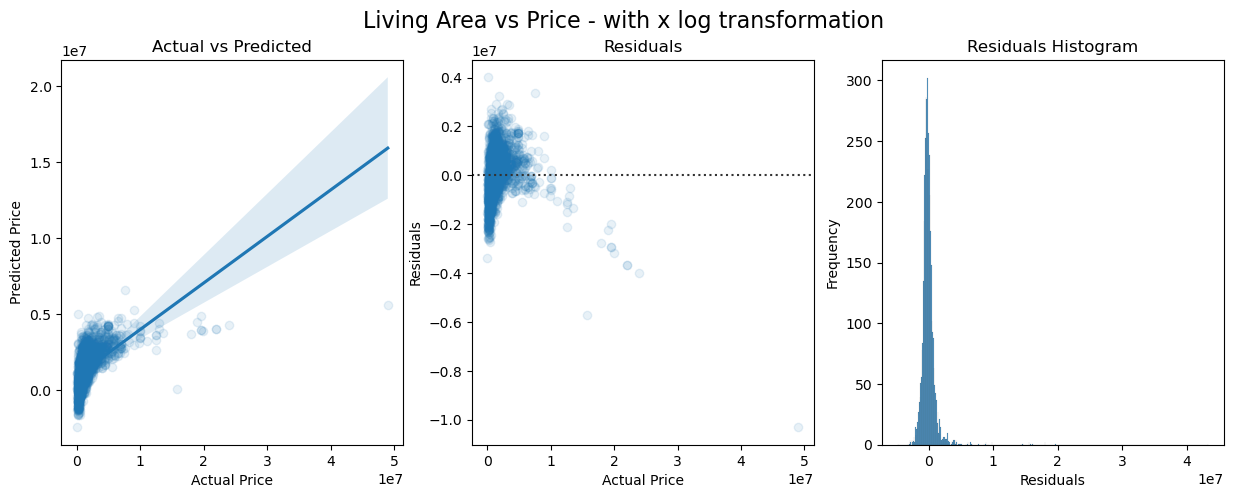

R2: 0.3048 - RMSE: 1433837.9500, MAE: 682242.5100



In [13]:
perform_linear_regression(X, y, np.log, None, True, "Living Area vs Price - with x log transformation")

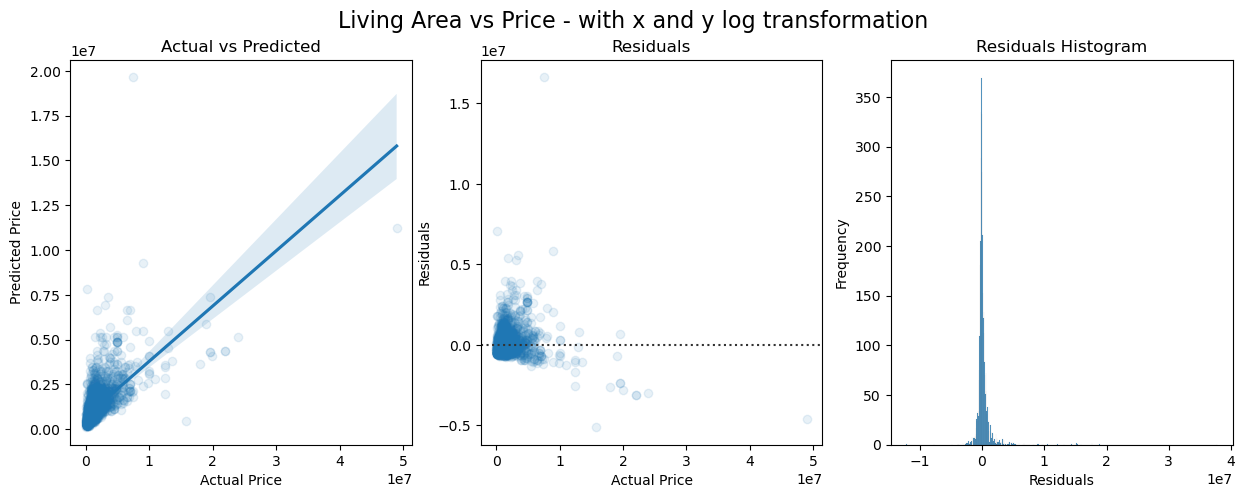

R2: 0.3744 - RMSE: 1360145.3700, MAE: 524850.1700



In [14]:
perform_linear_regression(X, y, np.log, np.log, True, "Living Area vs Price - with x and y log transformation")

Bei der Log-Transformation der x- und y-Variablen sehen wir eine minimale Verbesserung des Modells im Sinne des RMSE und MAE. Im Sinne des $R^2$ ist das Modell aber schlechter geworden.

### Quadrat-Transformation (Teilaufgabe 2.1.1)

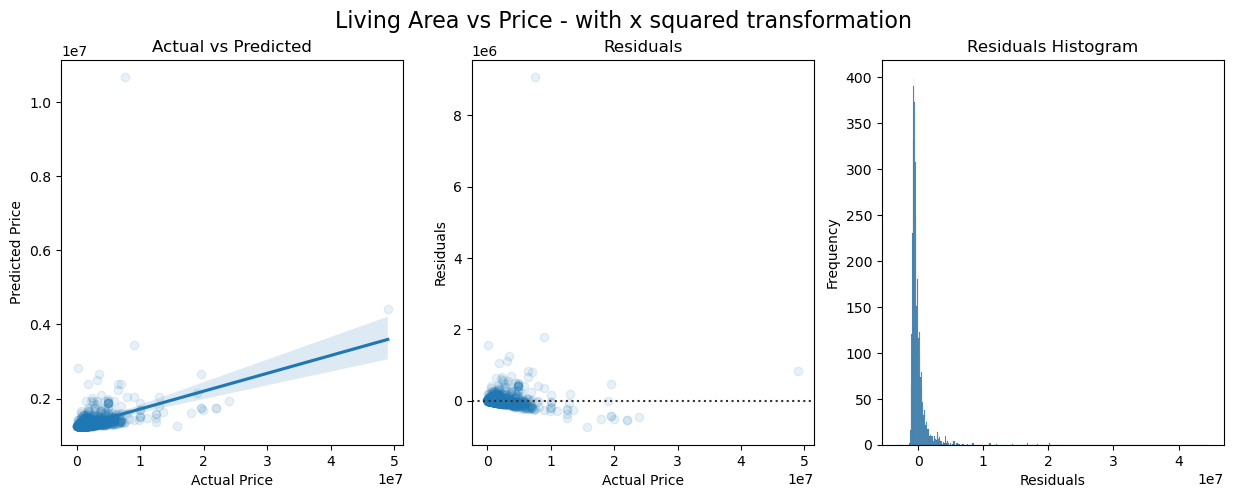

R2: 0.0846 - RMSE: 1645302.8500, MAE: 795996.3500



In [15]:
perform_linear_regression(X, y, np.square, None, True, "Living Area vs Price - with x squared transformation")

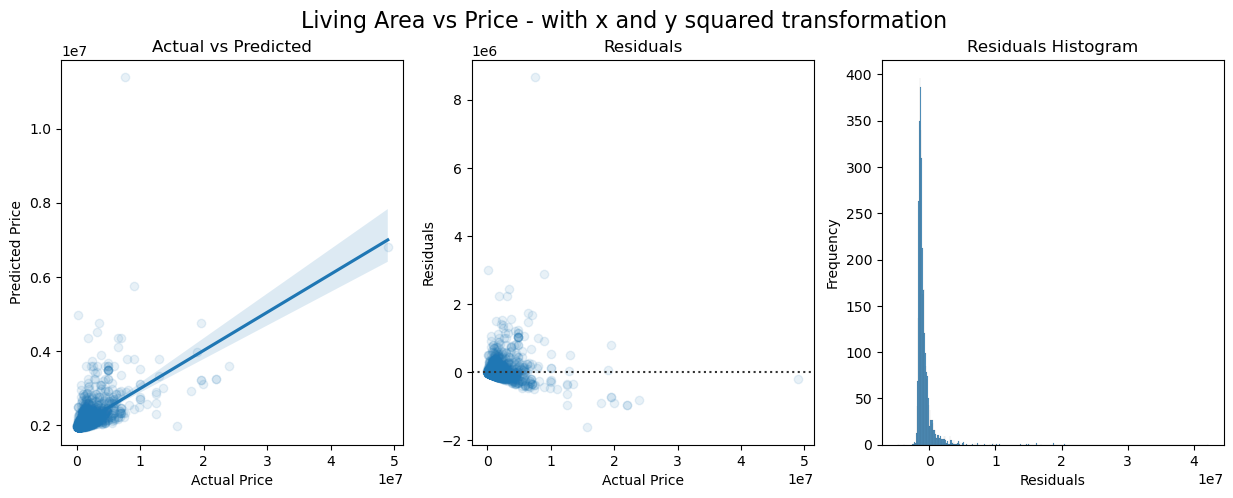

R2: -0.0416 - RMSE: 1754975.5600, MAE: 1246092.5000



In [16]:
perform_linear_regression(X, y, np.square, np.square, True, "Living Area vs Price - with x and y squared transformation")

Bei beiden Quadrat-Transformationen sehen wir erhebliche Verschlechterungen des Modells. Das $R^2$ ist sehr klein, die Residuen sind nicht mehr normalverteilt und es gibt noch grössere Ausreisser.

### Quadratwurzel-Transformation (Teilaufgabe 2.1.1)

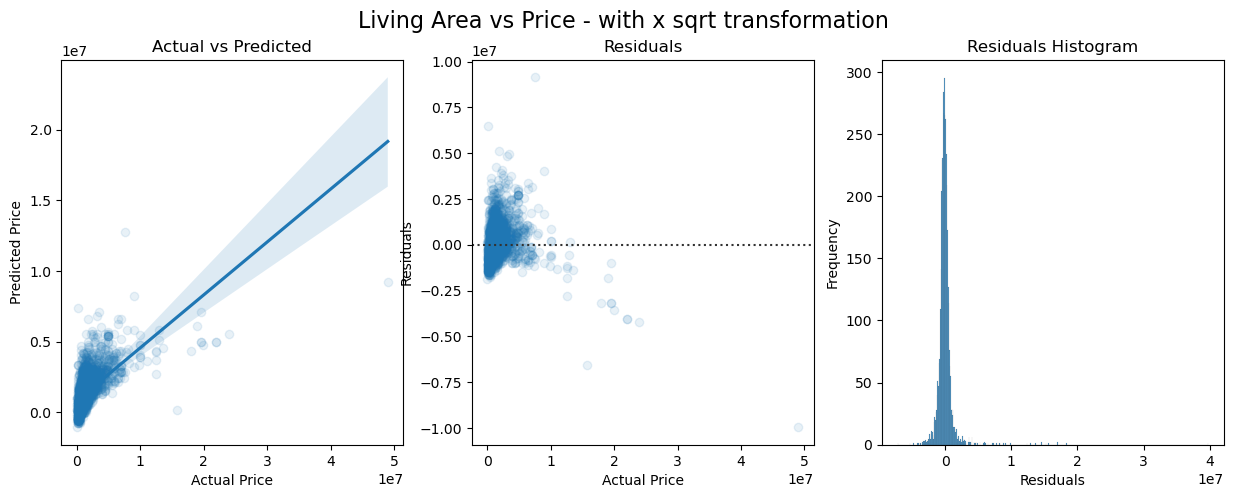

R2: 0.3815 - RMSE: 1352438.9000, MAE: 621362.0100



In [17]:
perform_linear_regression(X, y, np.sqrt, None, True, "Living Area vs Price - with x sqrt transformation")

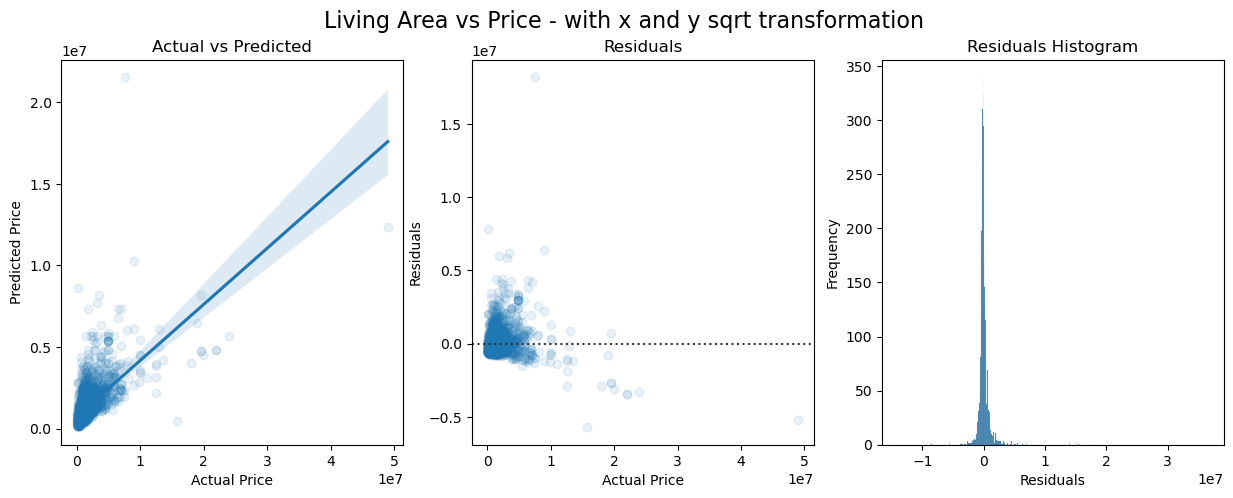

R2: 0.3983 - RMSE: 1333846.8700, MAE: 534759.8500



In [18]:
perform_linear_regression(X, y, np.sqrt, np.sqrt, True, "Living Area vs Price - with x and y sqrt transformation")

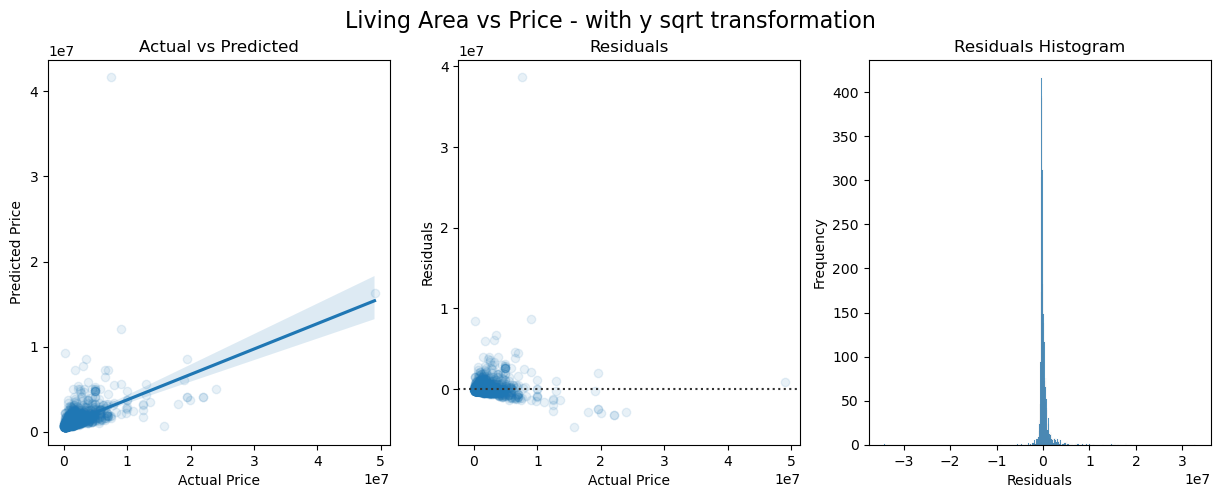

R2: 0.2886 - RMSE: 1450362.2100, MAE: 572916.3700



In [19]:
perform_linear_regression(X, y, None, np.sqrt, True, "Living Area vs Price - with y sqrt transformation")

Die Residuen der Quadratwurzel-Transformationen sehen alle gut normalverteilt aus. Aber grosse Verbesserungen des Modells sehen wir nicht.

### Interpretation (Teilaufgabe 2.1.1)

| Model | Transformation | R2 | RMSE | MAE |
| --- | --- | --- | --- | --- |
| 2.1.1 | Baseline - keine Transformation | 0.3932 | 1339575.9200| 570184.6900 |
| 2.1.1 | Log (x) | 0.3048 | 1433837.9500 | 682242.5100 |
| 2.1.1 | Log (x and y) | 0.3744 | 1360145.3700 | 524850.1700 |
| 2.1.1 | Quadrat (x) | 0.0846 | 1645302.8500 | 795996.3500 |
| 2.1.1 | Quadrat (x and y) | -0.0416 | 1754975.5600 | 1246092.5000 |
| 2.1.1 | Quadratwurzel (x) | 0.3815 | 1352438.9000 | 621362.0100 |
| 2.1.1 | Quadratwurzel (x and y) | 0.3983 | 1333846.8700 | 534759.8500 |
| 2.1.1 | Quadratwurzel (y) | 0.2886 | 1450362.2100 | 572916.3700 |

Das Modell mit Quadratwurzel (x und y) Transformation hat den höchsten R2-Wert (0.3983) und relativ niedrige Werte für RMSE und MAE. Dies deutet darauf hin, dass es unter den aufgeführten Modellen am besten die Variabilität der Daten erklärt und eine geringere Fehlerquote aufweist. Auf Basis dieser Analyse scheint es das beste unter den aufgelisteten zu sein.

Es wäre eventuell sinnvoll, eine Ausreisserbehandlung durchzuführen, um das Modell zu verbessern.

## Fehlende Werte bei `Floor_space_merged` ersetzen (Teilaufgabe 2.1.2)

Diese Teilaufgabe ist offensichtlich ein eher schlechter Ansatz, weil `Floor_space_merged` 19'000+ fehlende Werte hat. Das heisst wir ersetzen hier die meisten Werte mit `Living_area_unified`. Im Sinne der Experimente, führen wir das aber trotzdem druch.

In [20]:
# Replace missing 'Floor_space_merged' values with 'Living_area_unified' values
df_212['Floor_space_merged'] = df_212['Floor_space_merged'].fillna(df_212['Living_area_unified'])

# Subset dataset
df_212 = df_212[['Floor_space_merged', 'price_cleaned']]

# Drop na values
df_212 = df_212.dropna(subset=['Floor_space_merged'])

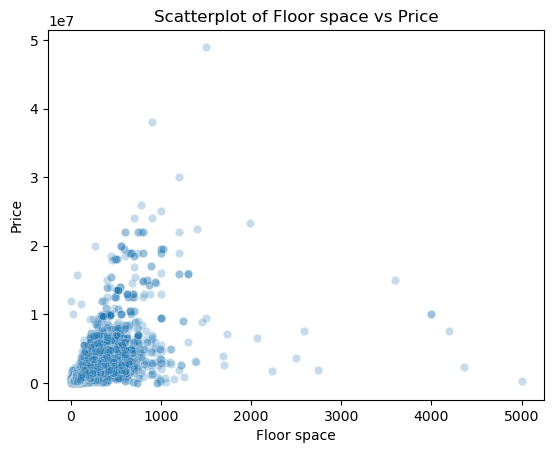

In [21]:
# Split dataset
X2 = df_212['Floor_space_merged']
y2 = df_212['price_cleaned']

sns.scatterplot(data=df_212, x=X2, y=y2, alpha=0.25)
plt.title('Scatterplot of Floor space vs Price')
plt.ylabel('Price')
plt.xlabel('Floor space')
plt.show()

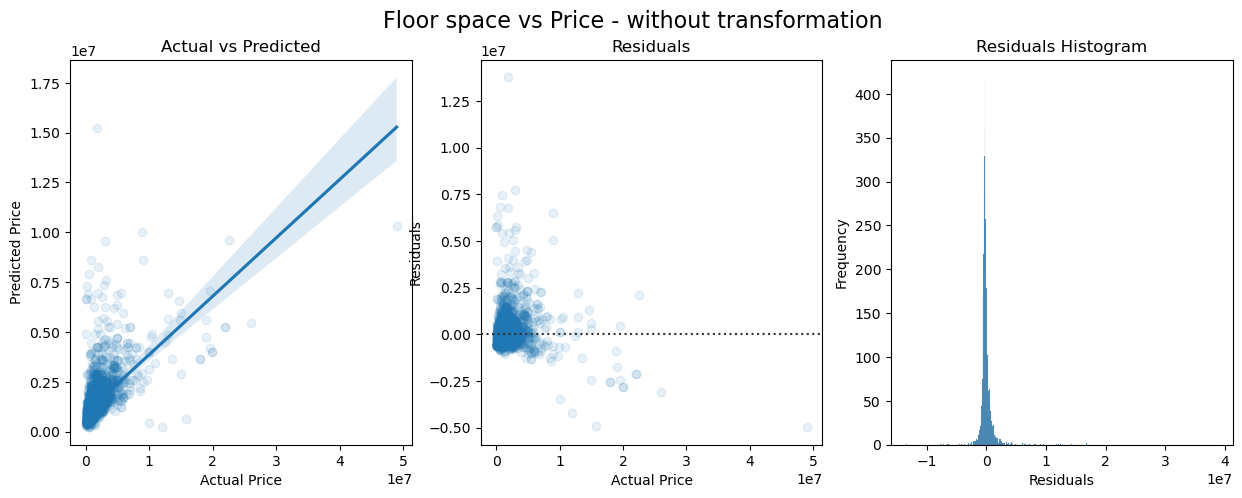

R2: 0.3499 - RMSE: 1489067.9300, MAE: 628984.7800



In [22]:
perform_linear_regression(X2, y2, None, None, True, "Floor space vs Price - without transformation")

### Log-Transformation (Teilaufgabe 2.1.2)

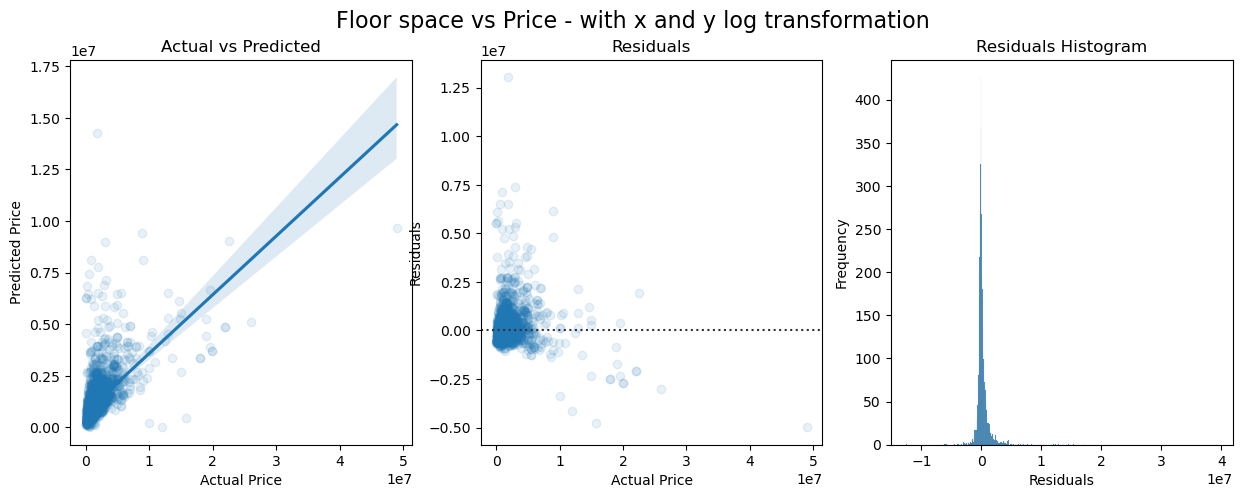

R2: 0.3335 - RMSE: 1507824.1500, MAE: 582392.9500



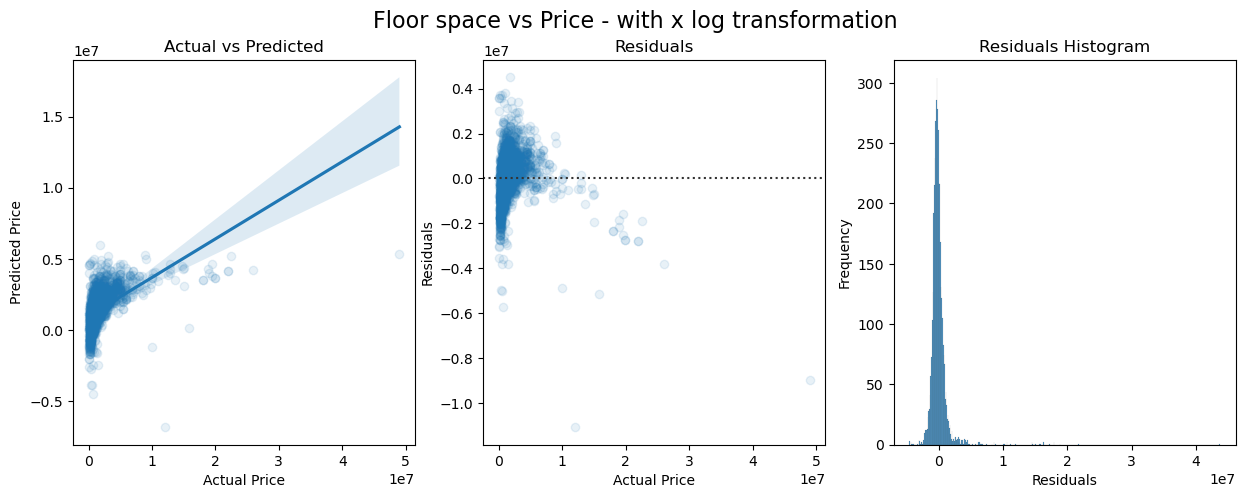

R2: 0.2586 - RMSE: 1590283.6200, MAE: 729437.8800



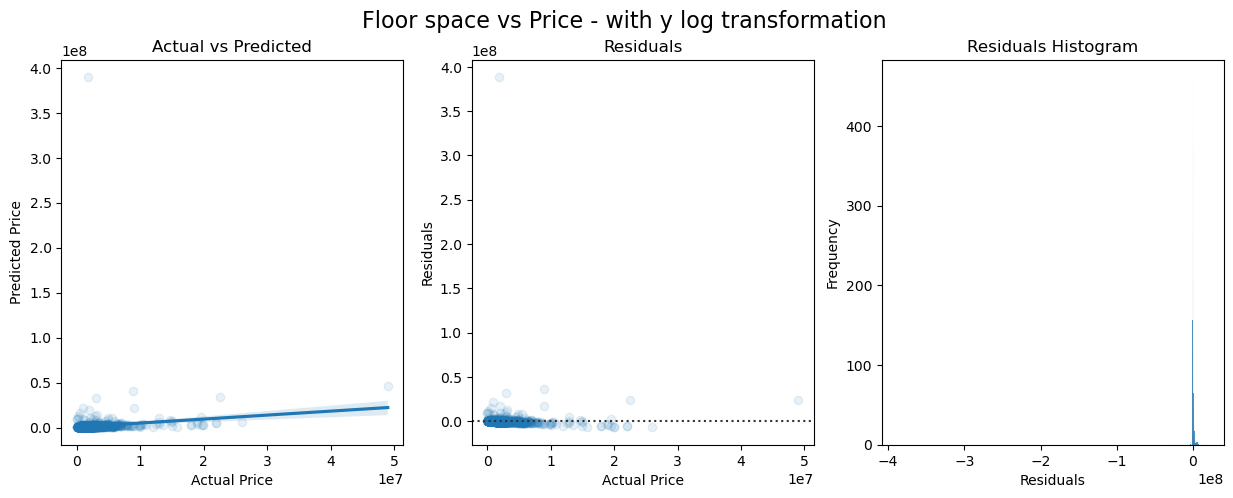

R2: -10.4703 - RMSE: 6254956.2100, MAE: 757846.1800



In [23]:
perform_linear_regression(X2, y2, np.log, np.log, True, "Floor space vs Price - with x and y log transformation")
perform_linear_regression(X2, y2, np.log, None, True, "Floor space vs Price - with x log transformation")
perform_linear_regression(X2, y2, None, np.log, True, "Floor space vs Price - with y log transformation")

### Quadrat-Transformation (Teilaufgabe 2.1.2)

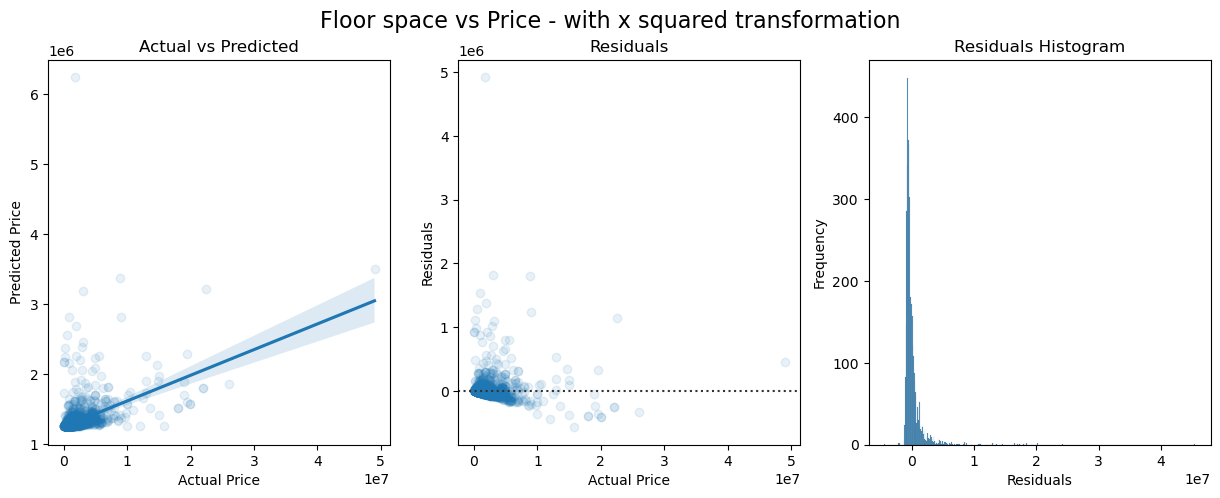

R2: 0.0671 - RMSE: 1783866.5200, MAE: 836359.6400



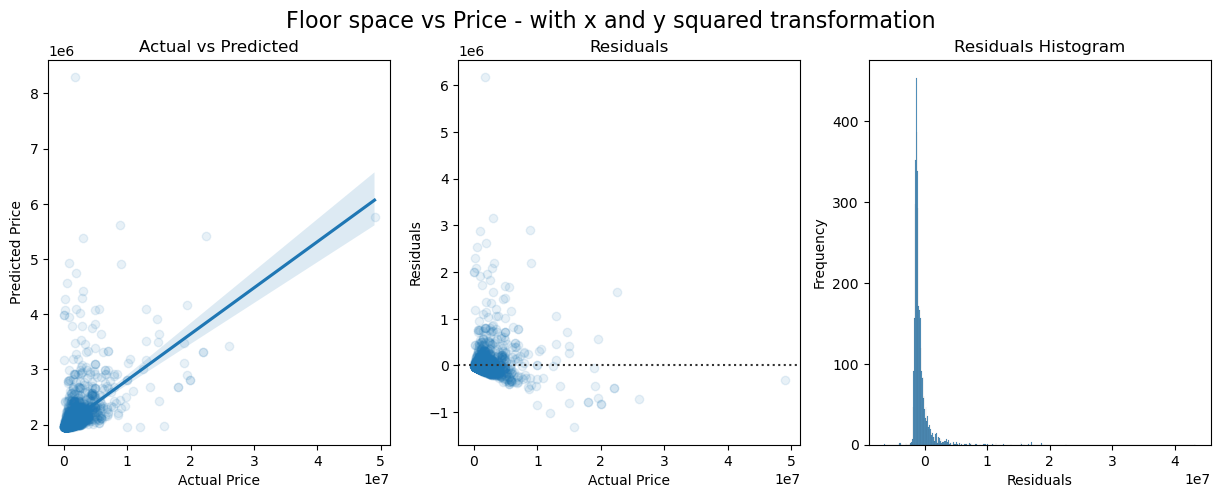

R2: -0.0179 - RMSE: 1863289.1400, MAE: 1264163.2400



In [24]:
perform_linear_regression(X2, y2, np.square, None, True, "Floor space vs Price - with x squared transformation")
perform_linear_regression(X2, y2, np.square, np.square, True, "Floor space vs Price - with x and y squared transformation")

### Quadratwurzel-Transformation (Teilaufgabe 2.1.2)

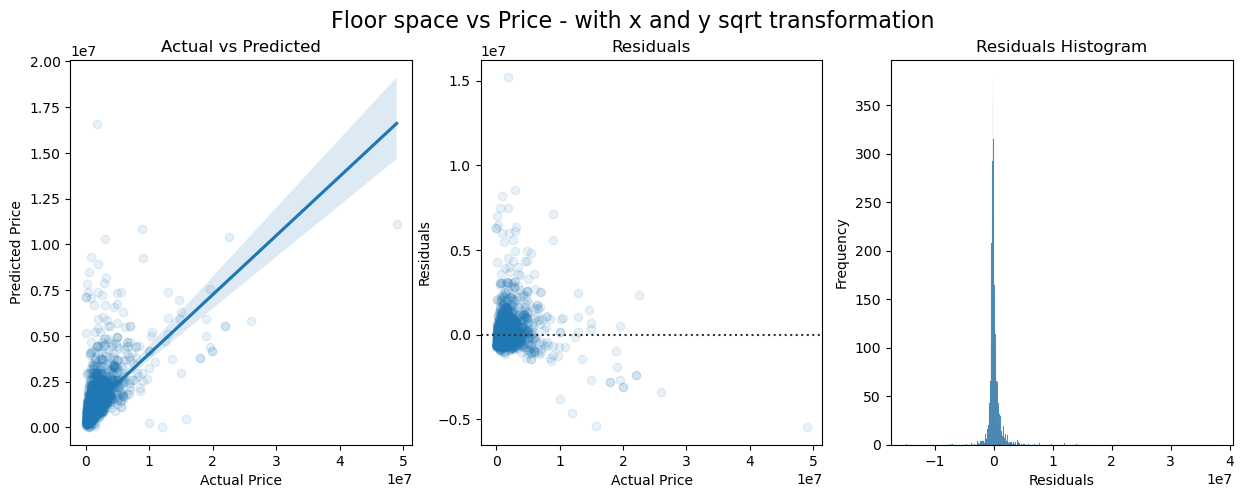

R2: 0.3555 - RMSE: 1482710.7800, MAE: 591063.3700



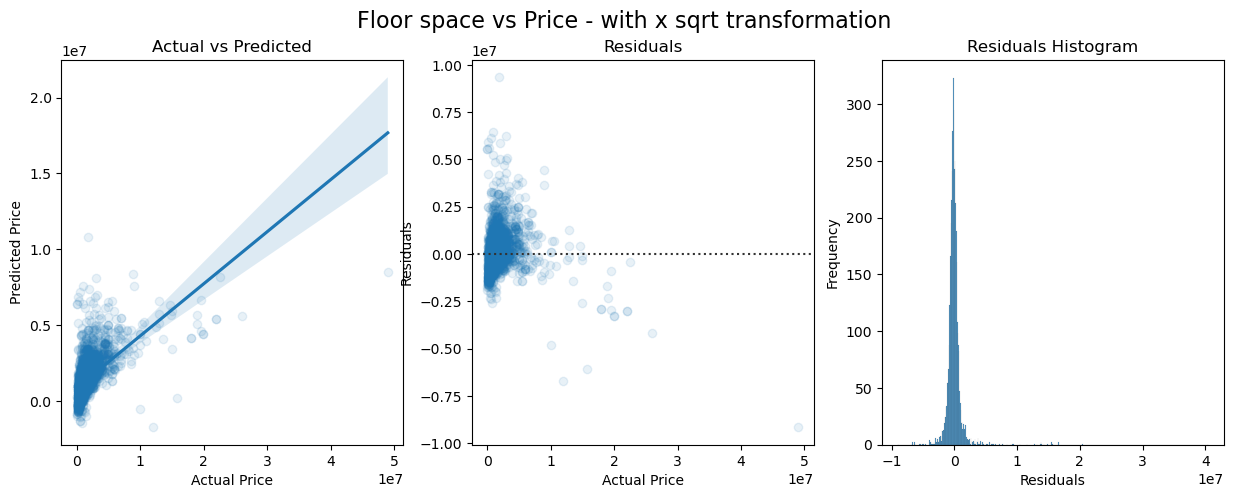

R2: 0.3438 - RMSE: 1496045.9100, MAE: 666437.9100



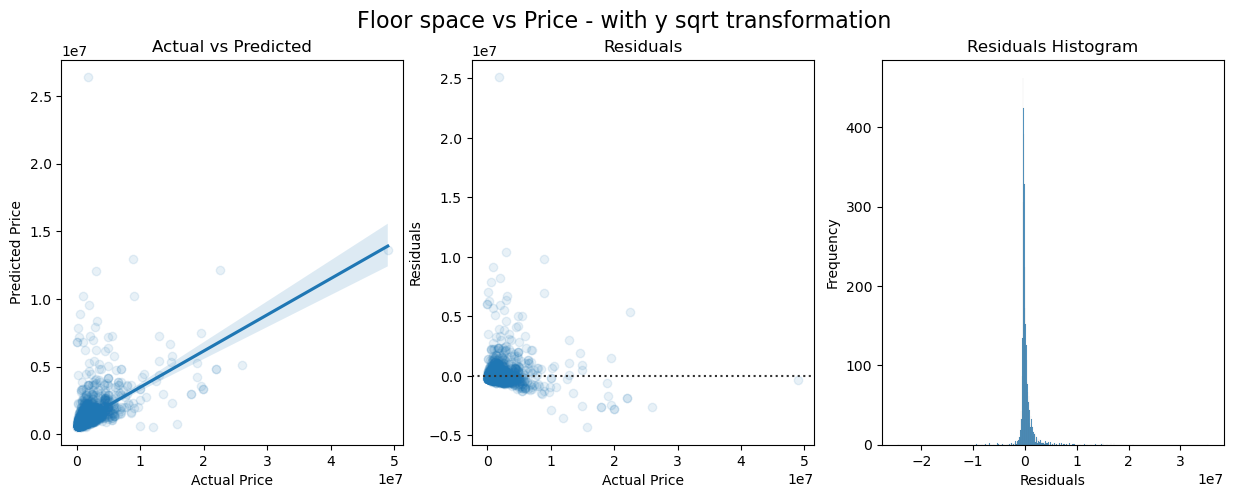

R2: 0.2881 - RMSE: 1558295.5300, MAE: 630991.2800



In [25]:
perform_linear_regression(X2, y2, np.sqrt, np.sqrt, True, "Floor space vs Price - with x and y sqrt transformation")
perform_linear_regression(X2, y2, np.sqrt, None, True, "Floor space vs Price - with x sqrt transformation")
perform_linear_regression(X2, y2, None, np.sqrt, True, "Floor space vs Price - with y sqrt transformation")

### Interpretation (Teilaufgabe 2.1.2)

| Model | Transformation | R2 | RMSE | MAE |
| --- | --- | --- | --- | --- |
| 2.1.2 | Baseline - keine Transformation | 0.3499 | 1489067.9300 | 628984.7800 |
| 2.1.2 | Log (x und y) | 0.3335 | 1507824.1500 | 582392.9500 |
| 2.1.2 | Log (x) | 0.2586 | 1590283.6200 | 729437.8800 |
| 2.1.2 | Log (y) | -10.4703 | 6254956.2100 | 757846.1800 |
| 2.1.2 | Quadrat (x und y) | -0.0179 | 1863289.1400 | 1264163.2400 |
| 2.1.2 | Quadrat (x) | 0.0671 | 1783866.5200 | 836359.6400 |
| 2.1.2 | Quadratwurzel (x und y) | 0.3555 | 1482710.7800 | 591063.3700 |
| 2.1.2 | Quadratwurzel (x) | 0.3438 | 1496045.9100 | 666437.9100 |
| 2.1.2 | Quadratwurzel (y) | 0.2881 | 1558295.5300 | 630991.2800 |

Wie nach Erwartung sehen wir, dass die Modelle bei diesem Experiment nicht besser geworden sind.

## Fehlende Werte bei `Living_area_unified` ersetzen (Teilaufgabe 2.1.3)

In [26]:
print(f"Anzahl fehlender Werte vor dem Imputing: {df_213['Living_area_unified'].isna().sum()}")

Anzahl fehlender Werte vor dem Imputing: 192


In [27]:
# Replace missing 'Living_area_unified' values with 'Floor_space_merged' values 
df_213['Living_area_unified'] = df_213['Living_area_unified'].fillna(df_213['Floor_space_merged'])

# Subset dataset
df_num212 = df_213[['Living_area_unified', 'price_cleaned']]

# Drop na values
df_num212 = df_213.dropna(subset=['Living_area_unified'])

In [28]:
print(f"Anzahl fehlender Werte nach dem Imputing: {df_num212['Living_area_unified'].isna().sum()}")

Anzahl fehlender Werte nach dem Imputing: 0


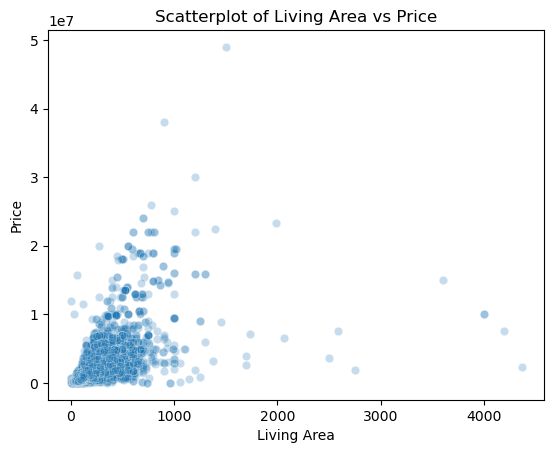

In [29]:
# Split dataset
X3 = df_213['Living_area_unified']
y3 = df_213['price_cleaned']

sns.scatterplot(data=df_213, x=X3, y=y3, alpha=0.25)
plt.title('Scatterplot of Living Area vs Price')
plt.ylabel('Price')
plt.xlabel('Living Area')
plt.show()

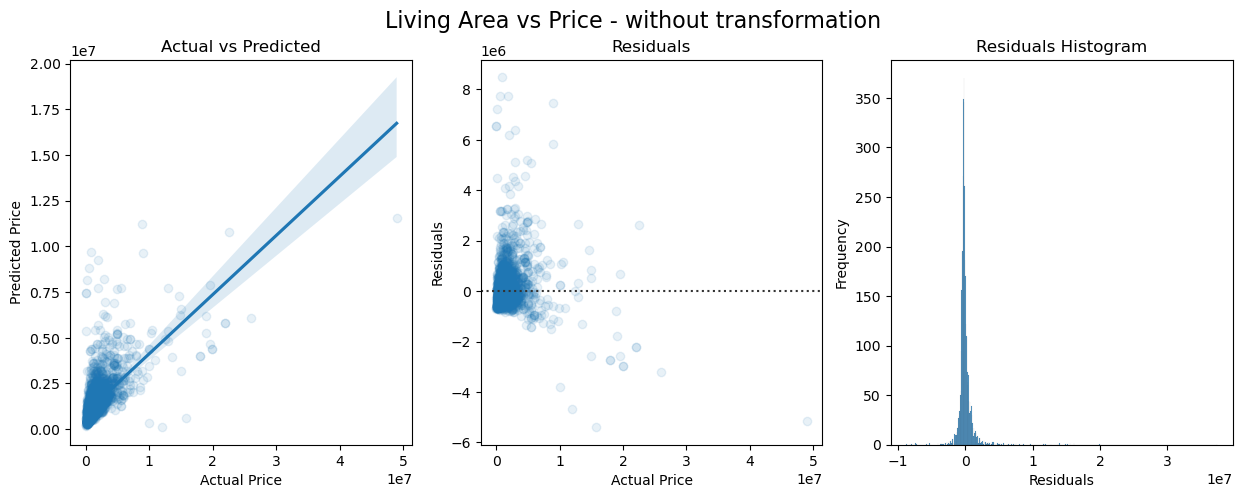

R2: 0.3993 - RMSE: 1431370.0900, MAE: 604510.4100



In [30]:
perform_linear_regression(X3, y3, None, None, True, "Living Area vs Price - without transformation")

### Log-Transformation (Teilaufgabe 2.1.3)

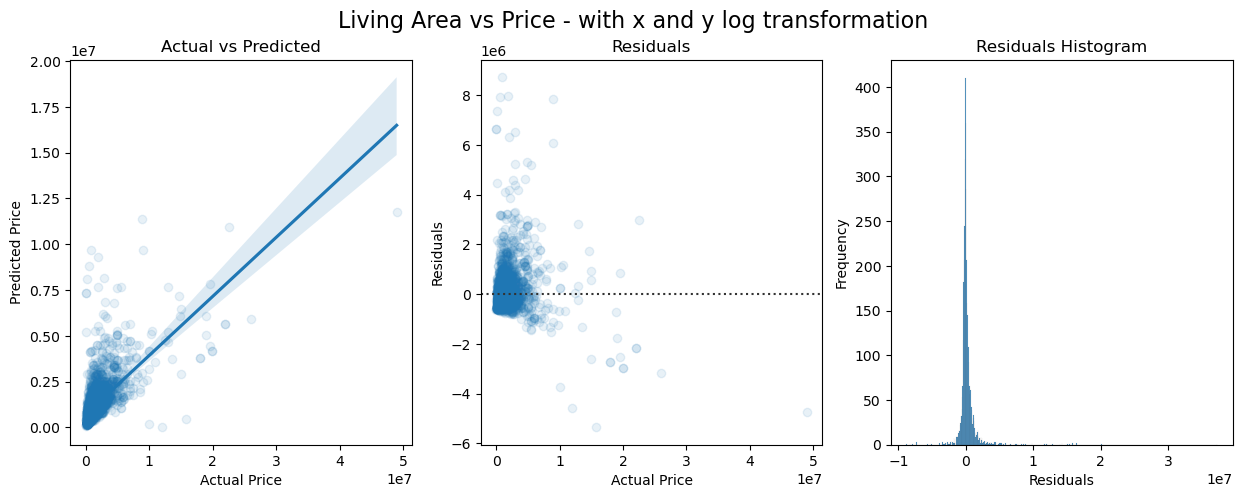

R2: 0.3879 - RMSE: 1444883.5700, MAE: 564085.7800



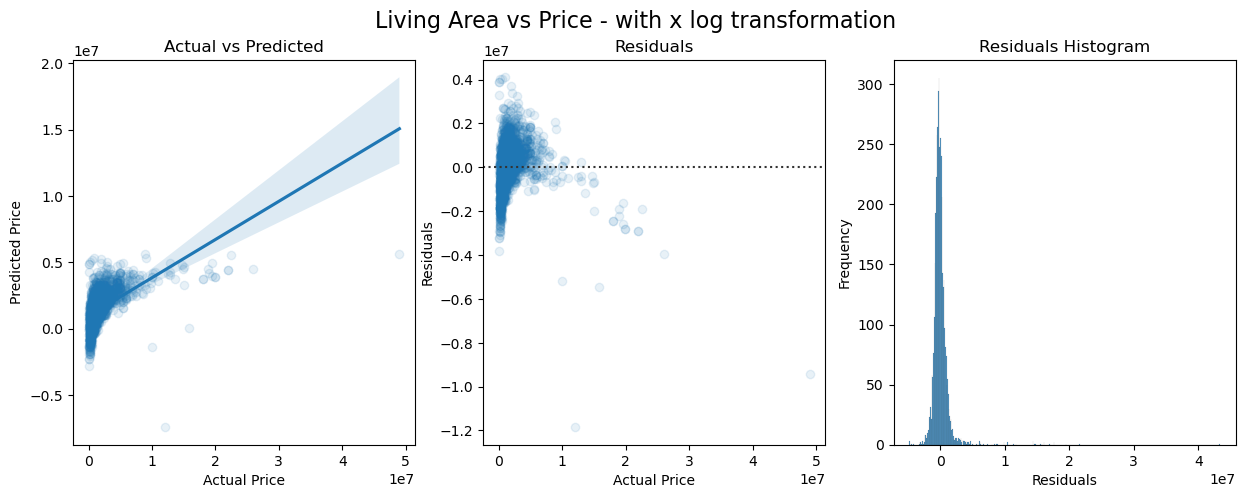

R2: 0.2802 - RMSE: 1566912.5400, MAE: 723867.9200



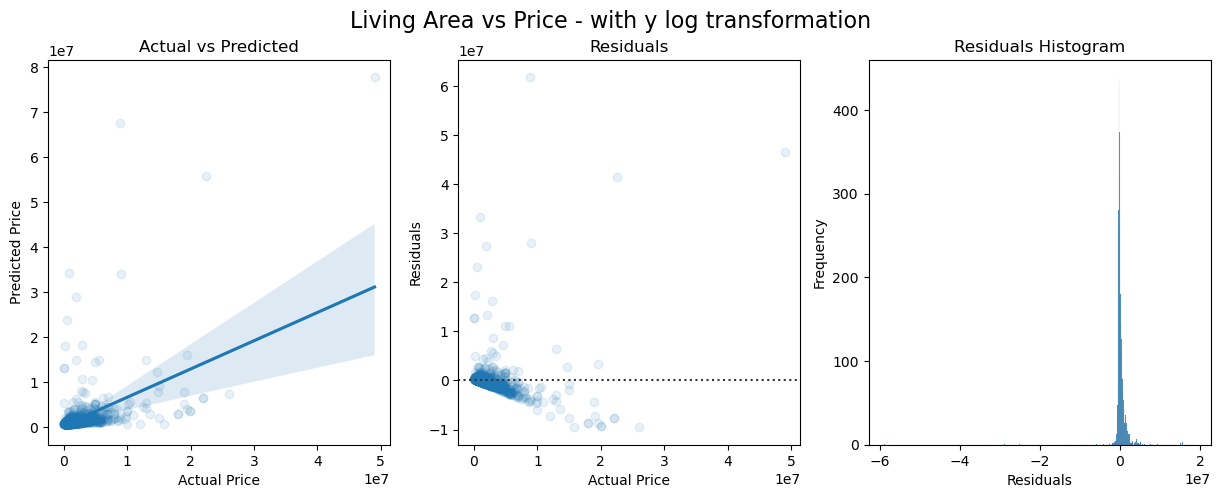

R2: -0.2018 - RMSE: 2024646.3900, MAE: 668169.3900



In [31]:
perform_linear_regression(X3, y3, np.log, np.log, True, "Living Area vs Price - with x and y log transformation")
perform_linear_regression(X3, y3, np.log, None, True, "Living Area vs Price - with x log transformation")
perform_linear_regression(X3, y3, None, np.log, True, "Living Area vs Price - with y log transformation")

### Quadrat-Transformation (Teilaufgabe 2.1.3)

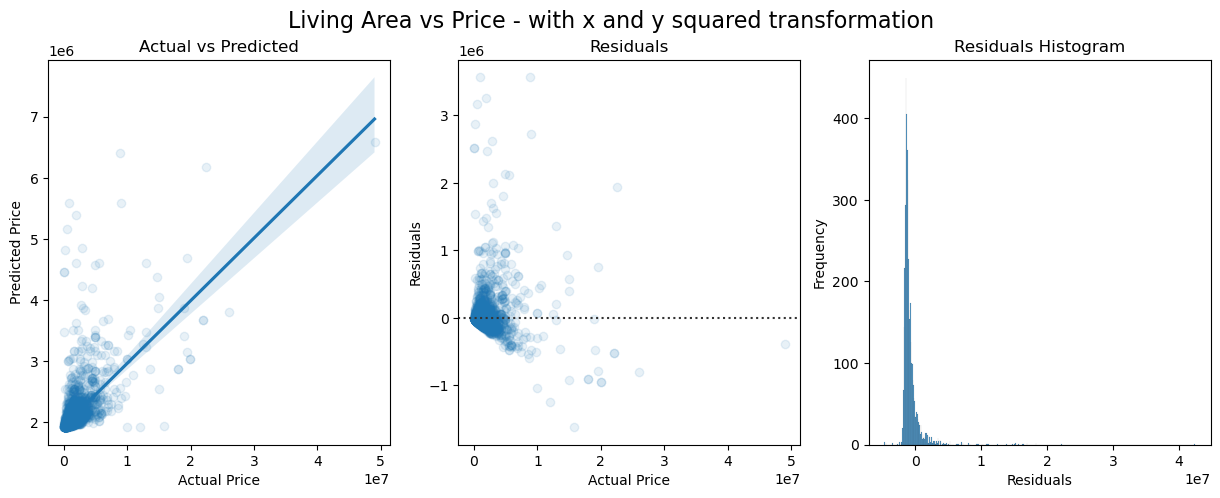

R2: 0.0196 - RMSE: 1828643.6700, MAE: 1243486.6600



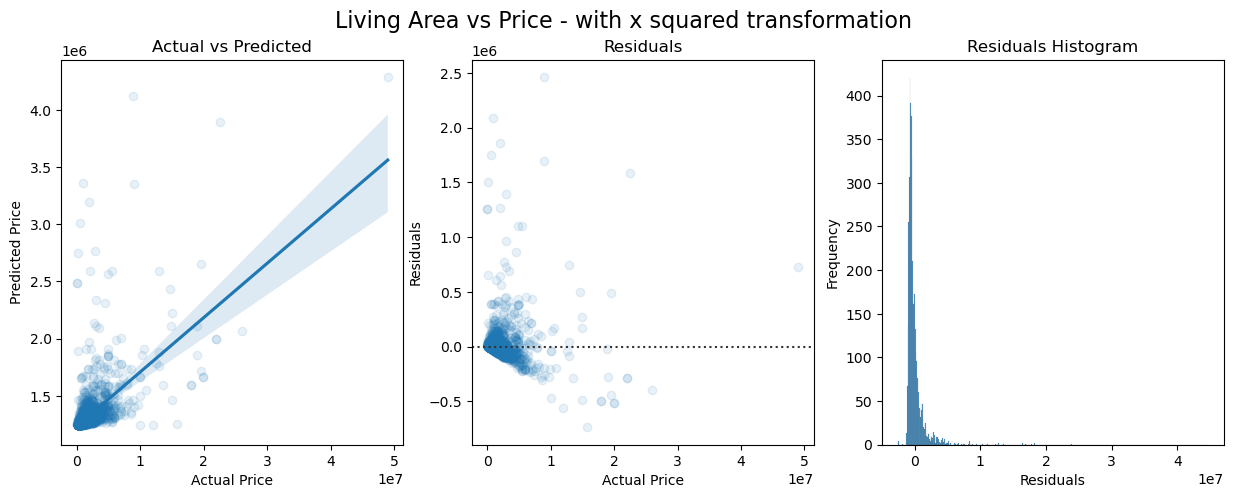

R2: 0.0884 - RMSE: 1763361.1100, MAE: 828685.3900



In [32]:
perform_linear_regression(X3, y3, np.square, np.square, True, "Living Area vs Price - with x and y squared transformation")
perform_linear_regression(X3, y3, np.square, None, True, "Living Area vs Price - with x squared transformation")

### Quadratwurzel-Transformation (Teilaufgabe 2.1.3)

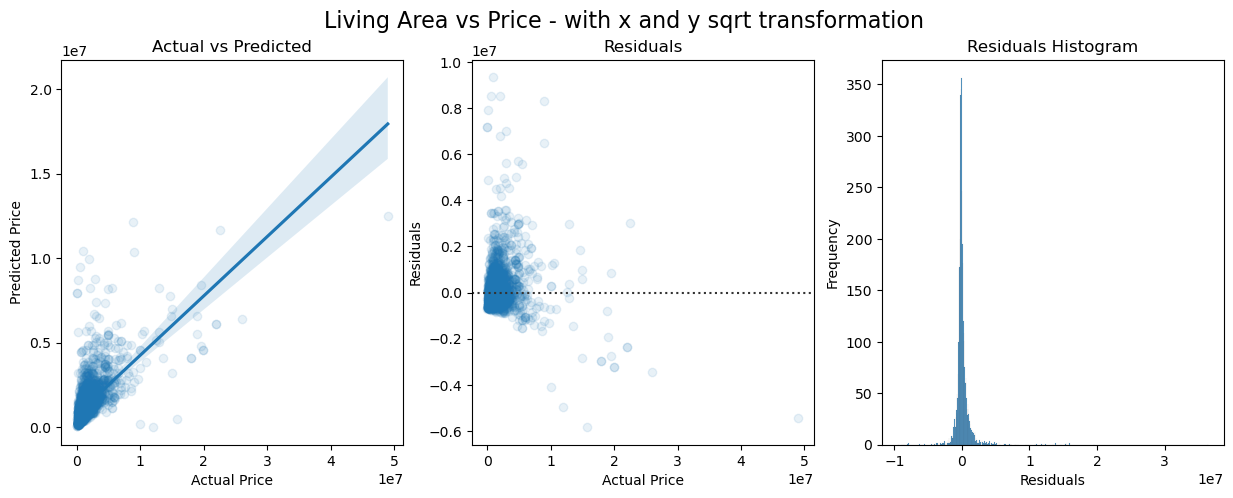

R2: 0.4078 - RMSE: 1421277.5000, MAE: 572081.8300



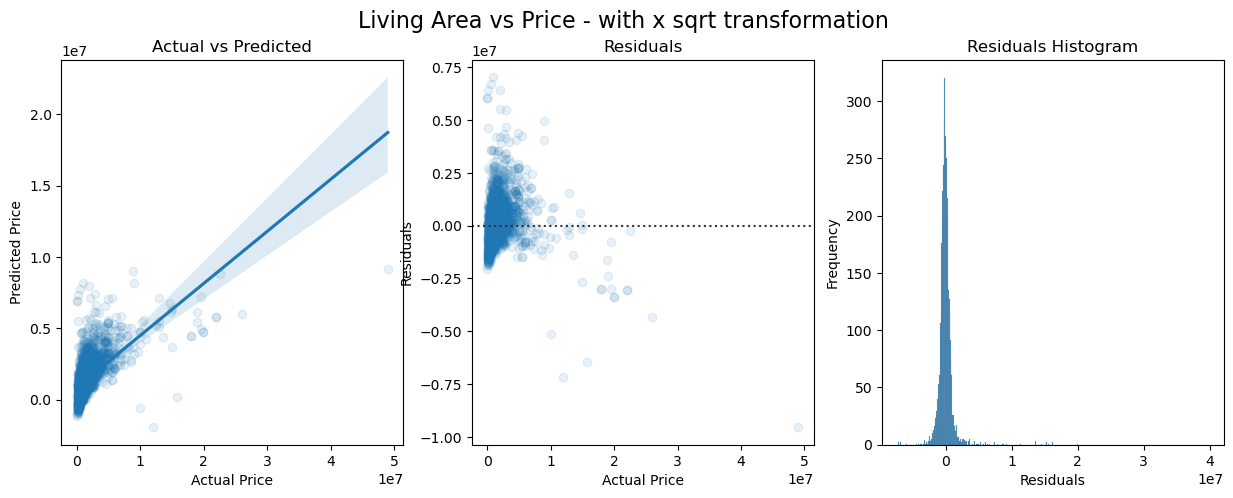

R2: 0.3753 - RMSE: 1459762.2900, MAE: 659822.3600



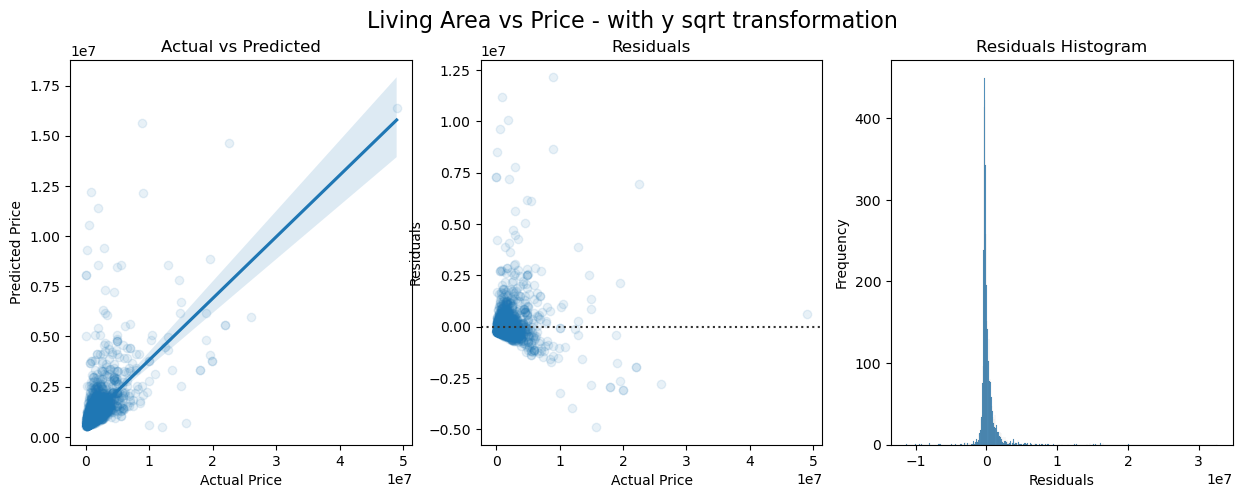

R2: 0.3761 - RMSE: 1458847.0100, MAE: 605729.8900



In [33]:
perform_linear_regression(X3, y3, np.sqrt, np.sqrt, True, "Living Area vs Price - with x and y sqrt transformation")
perform_linear_regression(X3, y3, np.sqrt, None, True, "Living Area vs Price - with x sqrt transformation")
perform_linear_regression(X3, y3, None, np.sqrt, True, "Living Area vs Price - with y sqrt transformation")

### Interpretation (Teilaufgabe 2.1.3)

| Model | Transformation | R2 | RMSE | MAE |
| --- | --- | --- | --- | --- |
| 2.1.3 | Baseline - Keine Transformation | 0.3993 | 1431370.0900 | 604510.4100 |
| 2.1.3 | Log (x und y ) | 0.3879 | 1444883.5700 | 564085.7800 |
| 2.1.3 | Log (x) | 0.2802 | 1566912.5400 | 723867.9200 |
| 2.1.3 | Log (y) | -0.2018 | 2024646.3900 | 668169.3900 |
| 2.1.3 | Quadrat (x und y)| 0.0196 | 1828643.6700 | 1243486.6600 |
| 2.1.3 | Quadrat (x)| 0.0884 | 1763361.1100 | 828685.3900 |
| 2.1.3 | Quadratwurzel (x und y) | 0.4078 | 1421277.5000 | 572081.8300 |
| 2.1.3 | Quadratwurzel (x)| 0.3753 | 1459762.2900 | 659822.3600 |
| 2.1.3 | Quadratwurzel (y) | 0.3761 | 1458847.0100 | 605729.8900 |

Bei dieser Teilaufgabe scheint das Modell mit der Quadratwurzel-Transformation von x und y ($R^2$: 0.4078) am effektivsten zu sein. Es hat den höchsten R2-Wert und den niedrigsten RMSE Wert. 

Wir sehen also eine Verbesserung der Modelle, wenn wir die fehlenden Werte von `Living_area_unified` mit `Floor_space_merged` ersetzen.

## Feature Engineering (Teilaufgabe 2.1.4)

In diesem Abschnitt versuchen wir anhand der beiden Features `Floor_space_merged` und `Living_area_unified` ein neues Feature zu generieren, das anstelle `Floor_space_merged` verwendet wird.

In [34]:
# Make df_num214['calc'] whatever value is bigger of df_num214['Living_area_unified'] or df_num214['Floor_space_merged']
df_214['calc'] = df_214[['Living_area_unified', 'Floor_space_merged']].max(axis=1)

# Subset dataset
df_214 = df_214[['calc', 'price_cleaned']]

# Drop na values
df_214 = df_214.dropna(subset=['calc'])

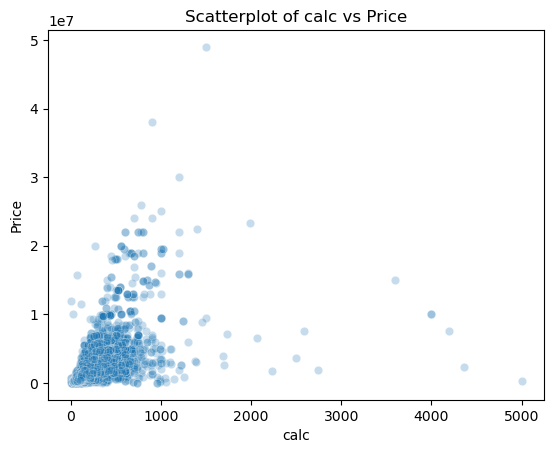

In [35]:
# Split dataset
X4 = df_214['calc']
y4 = df_214['price_cleaned']

sns.scatterplot(data=df_214, x=X4, y=y4, alpha=0.25)
plt.title('Scatterplot of calc vs Price')
plt.ylabel('Price')
plt.xlabel('calc')
plt.show()

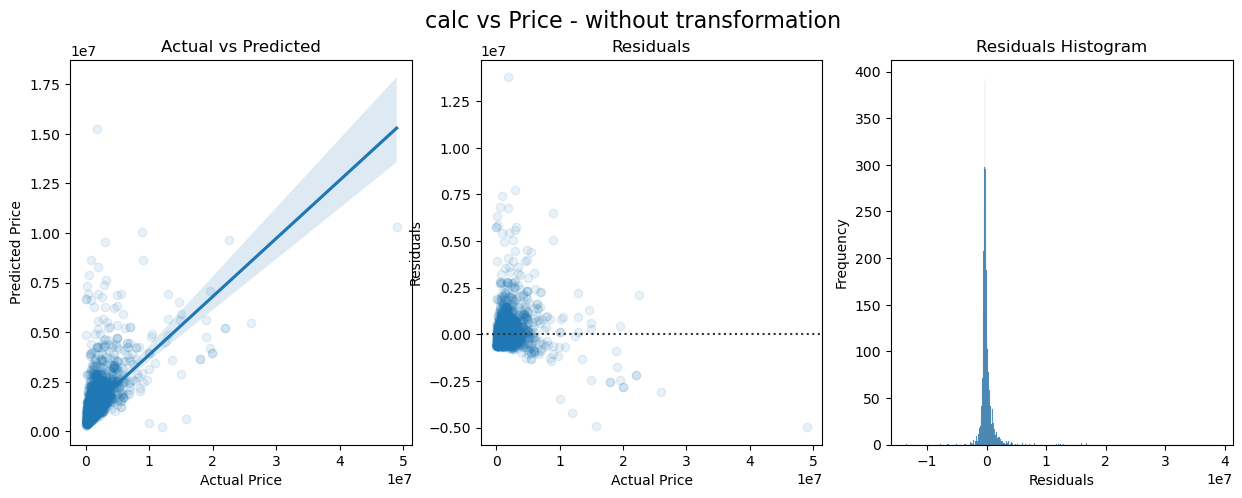

R2: 0.3505 - RMSE: 1488378.7900, MAE: 625766.4800



In [36]:
perform_linear_regression(X4, y4, None, None, True, "calc vs Price - without transformation")

### Log-Transformation (Teilaufgabe 2.1.4)

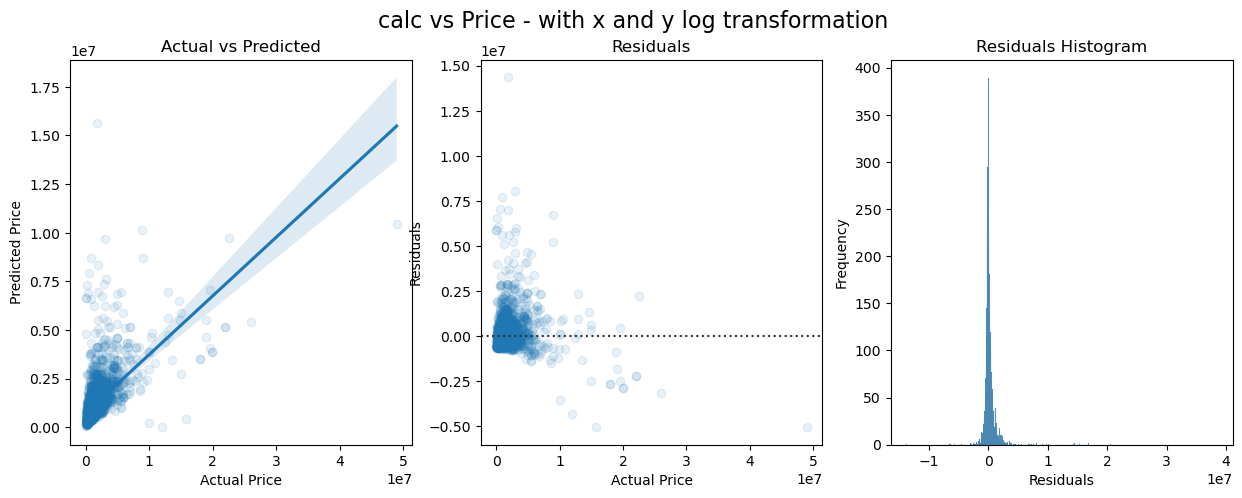

R2: 0.3413 - RMSE: 1498902.2600, MAE: 579782.0100



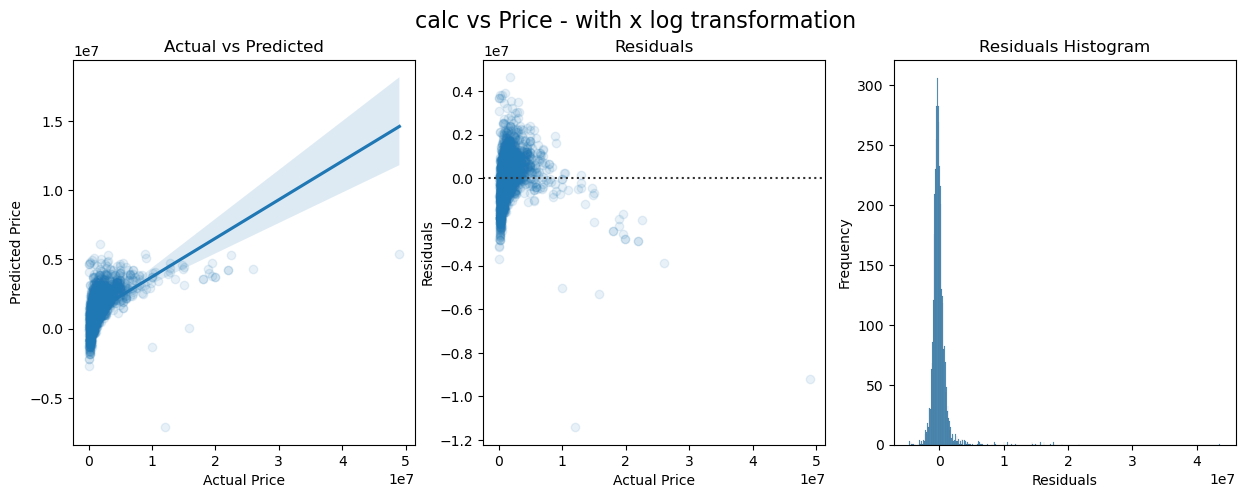

R2: 0.2686 - RMSE: 1579489.7500, MAE: 724371.6400



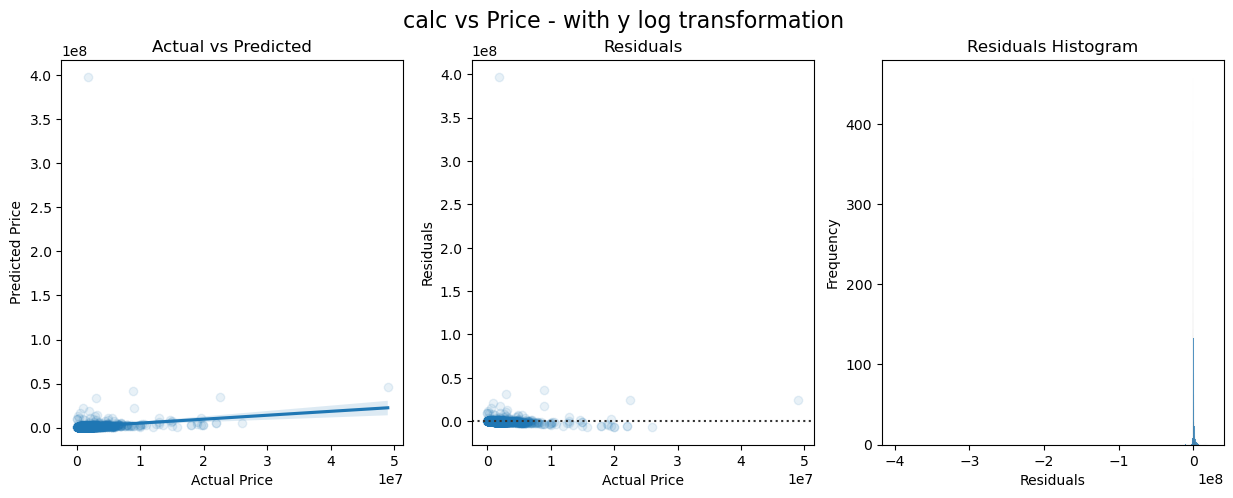

R2: -10.9442 - RMSE: 6382884.6900, MAE: 759422.7000



In [37]:
perform_linear_regression(X4, y4, np.log, np.log, True, "calc vs Price - with x and y log transformation")
perform_linear_regression(X4, y4, np.log, None, True, "calc vs Price - with x log transformation")
perform_linear_regression(X4, y4, None, np.log, True, "calc vs Price - with y log transformation")

### Quadrat-Transformation (Teilaufgabe 2.1.4)

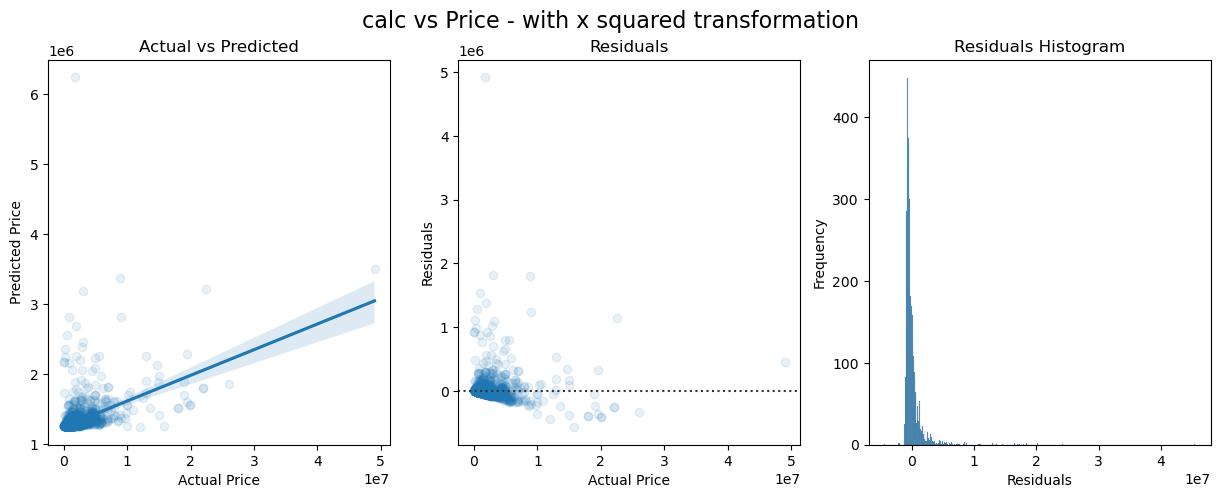

R2: 0.0671 - RMSE: 1783855.6000, MAE: 836263.0600



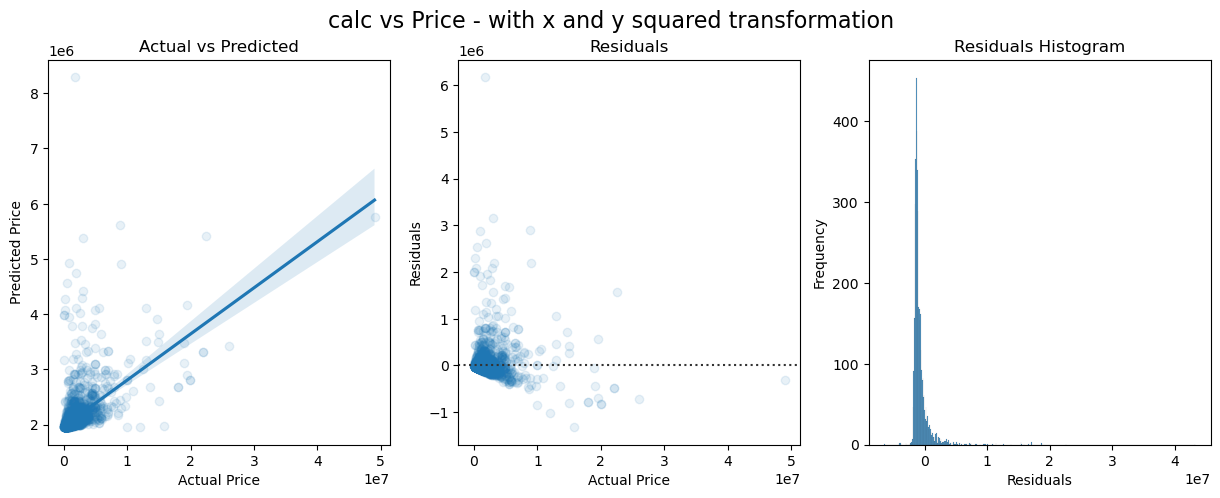

R2: -0.0178 - RMSE: 1863224.5400, MAE: 1264137.8100



In [38]:
perform_linear_regression(X4, y4, np.square, None, True, "calc vs Price - with x squared transformation")
perform_linear_regression(X4, y4, np.square, np.square, True, "calc vs Price - with x and y squared transformation")

### Quadratwurzel-Transformation (Teilaufgabe 2.1.4)

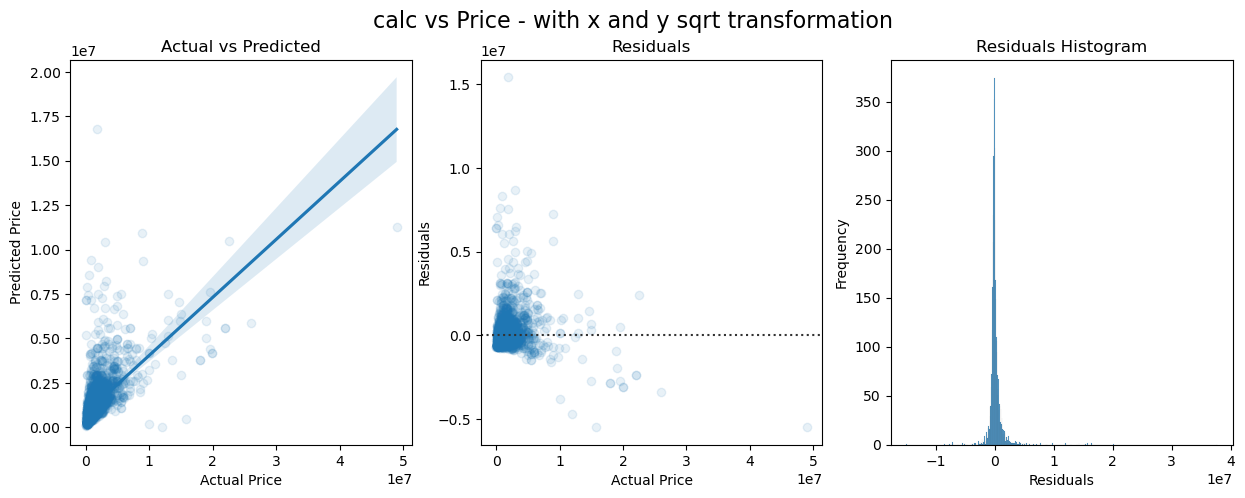

R2: 0.3568 - RMSE: 1481192.8000, MAE: 587623.4900



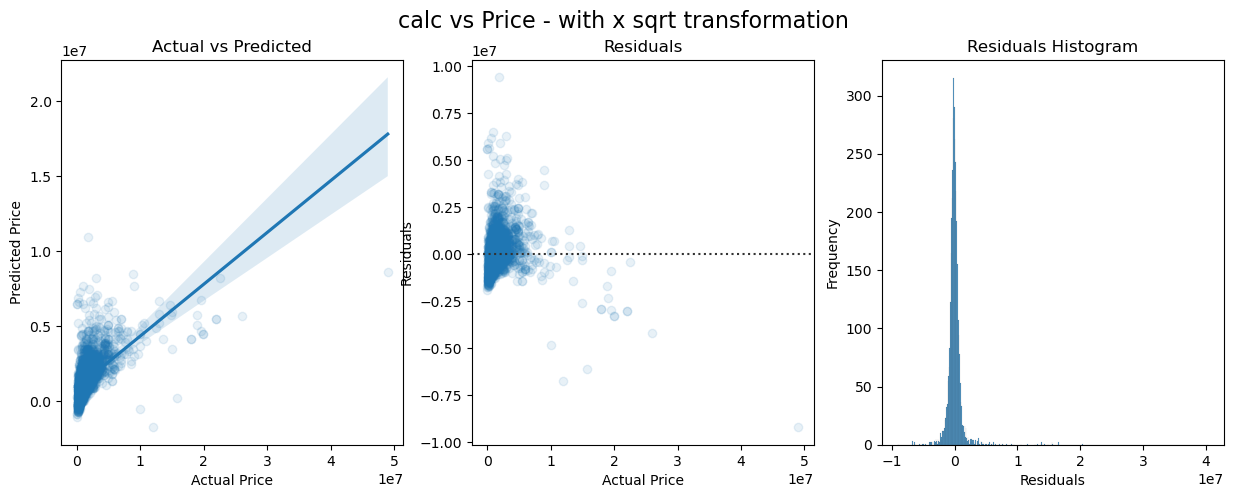

R2: 0.3470 - RMSE: 1492399.4000, MAE: 661346.8500



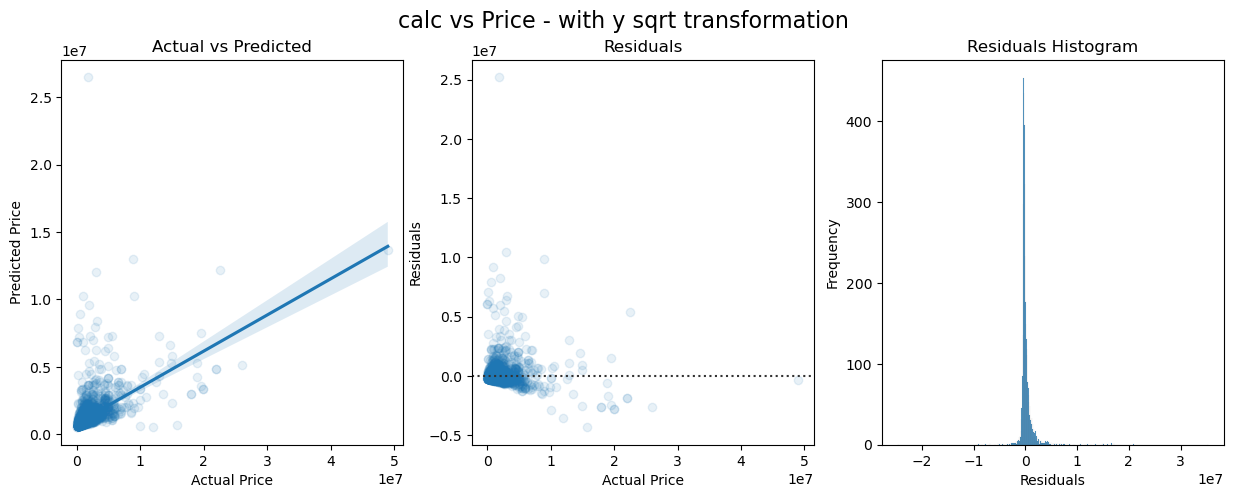

R2: 0.2881 - RMSE: 1558233.6700, MAE: 629332.8200



In [39]:
perform_linear_regression(X4, y4, np.sqrt, np.sqrt, True, "calc vs Price - with x and y sqrt transformation")
perform_linear_regression(X4, y4, np.sqrt, None, True, "calc vs Price - with x sqrt transformation")
perform_linear_regression(X4, y4, None, np.sqrt, True, "calc vs Price - with y sqrt transformation")

### Interpretation (Teilaufgabe 2.1.4)

| Model | Transformation | R2 | RMSE | MAE |
| --- | --- | --- | --- | --- |
| 2.1.4 | Baseline - keine Transformation | 0.3505 | 1488378.7900 | 625766.4800 |
| 2.1.4 | Log (x und y) | 0.3413 | 1498902.2600 | 579782.0100 |
| 2.1.4 | Log (x) | 0.2686 | 1579489.7500 | 724371.6400 |
| 2.1.4 | Log (y) | -10.9442 | 6382884.6900 | 759422.7000 |
| 2.1.4 | Quadrat (x) | 0.0671 | 1783855.6000 | 836263.0600 |
| 2.1.4 | Quadrat (x und y) | -0.0178 | 1863224.5400 | 1264137.8100 |
| 2.1.4 | Quadratwurzel (x und y) | 0.3568 | 21481192.8000 | 587623.4900 |
| 2.1.4 | Quadratwurzel (x) | 0.3470 | 1492399.4000 | 661346.8500 |
| 2.1.4 | Quadratwurzel (y) | 0.2881 | 1558233.6700 | 629332.8200 |

Diese Tabelle zeigt die Ergebnisse der neu generierten Variable `calc` und `price_cleaned`. Basierend auf den R2-Werten und den Fehlermetriken scheint wieder das Modell mit der Quadratwurzel-Transformation von x und y (R2: 0.3568) am besten abzuschneiden. Aber nicht besser als das Modell aus 2.1.3.

Hier nochmals das beste Modell 2.1.3 - fehlende Werte von `Living_area_unified` mit `Floor_space_merged` ersetzt:
- Quadratwurzel (x und y) 
- $R^2$: 0.4078 

## Outlier Handling

Wir haben verschiedene Methoden für das Outlier-Handling in unseren Daten angewendet, um sicherzustellen, dass unsere Analysen und Modelle zuverlässige Ergebnisse liefern. Hierbei haben wir sowohl das Interquartilsbereich (IQR)-Verfahren als auch den Z-Score-Ansatz verwendet, um Ausreisser zu identifizieren und zu entfernen.

In [40]:
def perform_linear_regression_r2(X, y, x_transformation_func=None, y_transformation_func=None):
    """
    Performs linear regression on the provided dataset and returns the R2 score.
    """

    # Apply transformation if provided
    if x_transformation_func:
        X = x_transformation_func(X)

    if y_transformation_func:
        y = y_transformation_func(y)
    
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train linear regression model
    lin_reg = LinearRegression()

    if len(X_train.shape) == 1:
        lin_reg.fit(X_train.values.reshape(-1, 1), y_train)
        y_pred = lin_reg.predict(X_test.values.reshape(-1, 1))
    else:
        lin_reg.fit(X_train, y_train)
        y_pred = lin_reg.predict(X_test)

    # Transform back to original scale
    if y_transformation_func and y_transformation_func.__name__ == 'log':
        y_pred = np.exp(y_pred)
        y_test = np.exp(y_test)
    elif y_transformation_func and y_transformation_func.__name__ == 'sqrt':
        y_pred = np.square(y_pred)
        y_test = np.square(y_test)
    elif y_transformation_func and y_transformation_func.__name__ == 'square':
        y_pred = np.sqrt(y_pred)
        y_test = np.sqrt(y_test)

    r2 = round(r2_score(y_test, y_pred),4)
    
    return r2

### IQR

Für das IQR-Verfahren haben wir zunächst einen Bereich von unteren und oberen Prozentilen definiert, um die Flexibilität bei der Identifizierung von Ausreissern zu erhöhen. Wir haben dann die IQR für die relevanten Variablen in unseren Daten berechnet und die unteren und oberen Whisker-Grenzwerte definiert. Alle Datenpunkte, die ausserhalb dieser Grenzwerte lagen, wurden als Ausreisser betrachtet und aus unserem Datensatz entfernt. Anschliessend haben wir die R2-Werte für verschiedene Kombinationen von unteren und oberen Prozentilen berechnet, um die Auswirkungen des Outlier-Handlings auf die Modellleistung zu bewerten. Die Ergebnisse sind in der Visualisierung zu sehen und die optimale Kombination von unteren und oberen Prozentilen ist unten aufgeführt.

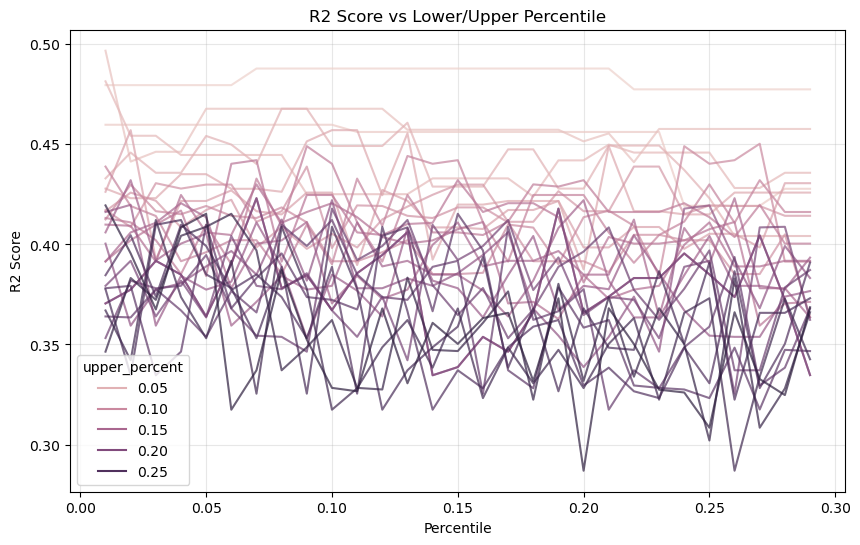

Best R2 Score:
   lower_percent  upper_percent  R2 Score  Amount of Entries
2           0.01           0.03    0.4968              20722


In [41]:
threshold_range = np.arange(1, 30, 1) / 100
results = []

# Iterate over all combinations of lower and upper percentiles
for lower_percent, upper_percent in itertools.product(threshold_range, threshold_range):
    Q1 = df_213['Living_area_unified'].quantile(lower_percent)
    Q3 = df_213['Living_area_unified'].quantile(1 - upper_percent)
    IQR = Q3 - Q1

    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR

    Q12 = df_213['price_cleaned'].quantile(lower_percent)
    Q32 = df_213['price_cleaned'].quantile(1 - upper_percent)
    IQR2 = Q32 - Q12

    Lower_Whisker2 = Q12 - 1.5 * IQR2
    Upper_Whisker2 = Q32 + 1.5 * IQR2

    df_num2133 = df_213[(df_213['Living_area_unified'] > Lower_Whisker) & (df_213['Living_area_unified'] < Upper_Whisker)]
    X33 = df_num2133['Living_area_unified']
    y33 = df_num2133['price_cleaned']

    # Calculate R2 score
    r2 = perform_linear_regression_r2(X33, y33, np.sqrt, np.sqrt)

    results.append({'lower_percent': lower_percent, 'upper_percent': upper_percent, 'R2 Score': r2, 'Amount of Entries': df_num2133.shape[0]})

# Create a DataFrame from the results list
r2_scores = pd.DataFrame(results)

# Plot the results
plt.figure(figsize=(10, 6))
sns.lineplot(data=r2_scores, x='lower_percent', y='R2 Score', hue='upper_percent', alpha=0.7)
plt.title('R2 Score vs Lower/Upper Percentile')
plt.ylabel('R2 Score')
plt.xlabel('Percentile')
plt.grid(True, alpha=0.3)
plt.show()

# Print the best R2 score
best_r2 = r2_scores.sort_values(by='R2 Score', ascending=False).head(1)
print("Best R2 Score:")
print(best_r2)


### Z-Score

Zusätzlich dazu haben wir den Z-Score verwendet, um Ausreisser zu identifizieren. Hierbei haben wir verschiedene Schwellenwerte für den Z-Score getestet und alle Datenpunkte entfernt, die den festgelegten Schwellenwert überschritten haben. Auch hier haben wir die R2-Werte für verschiedene Schwellenwerte berechnet, um die Auswirkungen auf die Modellleistung zu bewerten.

In [42]:
r2_scores = []
threshold_range = np.arange(0.5, 50, 0.5)

In [43]:
for threshold in threshold_range:
    df_temp = df_213.copy()
    z = np.abs(stats.zscore(df_temp['Living_area_unified']))
    df_temp = df_temp[(z < threshold)]
    X34 = df_temp['Living_area_unified']
    y34 = df_temp['price_cleaned']
    r2 = perform_linear_regression_r2(X34, y34, None, None)
    r2_scores.append(r2)

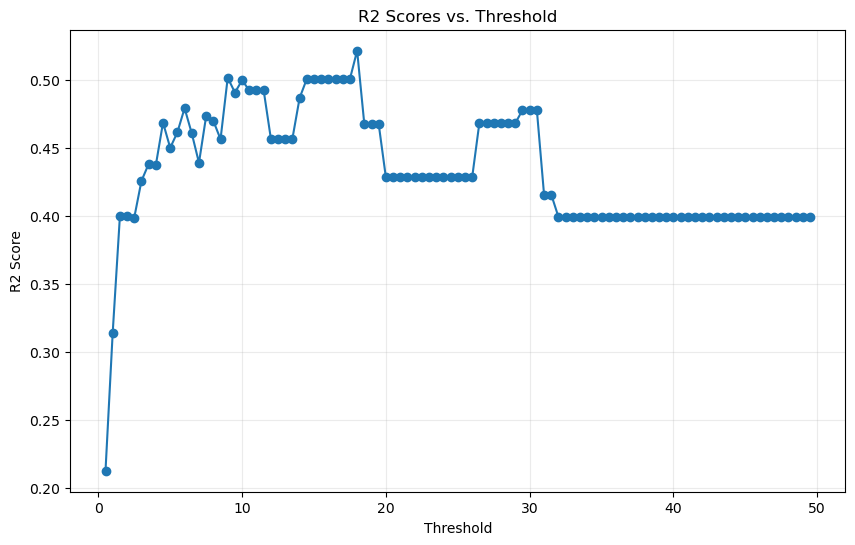

Max R2 Score: 0.5213


In [44]:
plt.figure(figsize=(10, 6))
plt.plot(threshold_range, r2_scores, marker='o', linestyle='-')
plt.title('R2 Scores vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('R2 Score')
plt.grid(True, alpha=0.25)
plt.show()
print('Max R2 Score:', np.max(r2_scores))

In [45]:
# Get index of max r2 score
max_r2_index = np.argmax(r2_scores)

# Get threshold value
threshold = max_r2_index / 2 + 0.5

df_temp = df_213.copy()

# Calculate z-score
z = np.abs(stats.zscore(df_temp['Living_area_unified']))

# Keep all entries with z-score < threshold
df_temp = df_temp[(z < threshold)]

X34 = df_temp['Living_area_unified']
y34 = df_temp['price_cleaned']

print("Anzahl der Datenpunkte vor Entfernen von Ausreissern:", df_213.shape[0])
print("Neue Anzahl der Datenpunkte nach Entfernen von Ausreissern:", df_temp.shape[0])

Anzahl der Datenpunkte vor Entfernen von Ausreissern: 20755
Neue Anzahl der Datenpunkte nach Entfernen von Ausreissern: 20748


Wir sehen also, dass das beste Modell im Sinne des $R^2$ nur 7 Ausreisser entfernt hat. Das bedeutet, dass diese 7 Ausreisser einen grossen Einfluss auf die Modellleistung hatten.

Schauen wir nun die Residuen an.

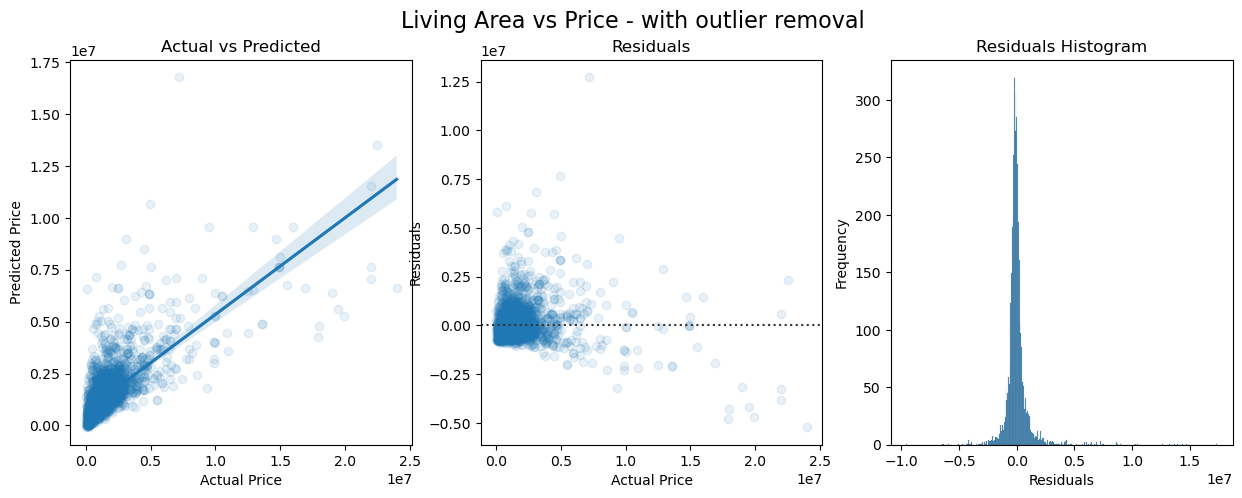

R2: 0.5213 - RMSE: 1179279.2600, MAE: 555138.4500



In [46]:
perform_linear_regression(X34, y34, None, None, True, "Living Area vs Price - with outlier removal")

Die Residuen im zweiten Plot sind nun besser um die Null verteilt, aber treffen immer noch nicht die Annahmen einer Residuenanalyse, da die Verteilung um Null sehr zufällig ist.

### Transformationen

Wir stellen uns jetzt die Frage, ob wir die Modellleistung durch Transformationen der Variablen verbessern können.

In [47]:
perform_linear_regression(X34, y34, np.log, np.log, False, "Living Area vs Price - with x and y log transformation")
perform_linear_regression(X34, y34, np.log, None, False, "Living Area vs Price - with x log transformation")
perform_linear_regression(X34, y34, None, np.log, False, "Living Area vs Price - with y log transformation")

Living Area vs Price - with x and y log transformation
R2: 0.4524 - RMSE: 1261284.2300, MAE: 532575.2900

Living Area vs Price - with x log transformation
R2: 0.3645 - RMSE: 1358776.6400, MAE: 682822.6500

Living Area vs Price - with y log transformation
R2: -48.1833 - RMSE: 11953164.0100, MAE: 819575.6700



In [48]:
perform_linear_regression(X34, y34, np.square, None, False, "Living Area vs Price - with x square transformation")

Living Area vs Price - with x square transformation
R2: 0.3696 - RMSE: 1353304.4900, MAE: 689117.5000



In [49]:
perform_linear_regression(X34, y34, np.sqrt, np.sqrt, False, "Living Area vs Price - with x and y sqrt transformation")
perform_linear_regression(X34, y34, np.sqrt, None, False, "Living Area vs Price - with x sqrt transformation")
perform_linear_regression(X34, y34, None, np.sqrt, False, "Living Area vs Price - with y sqrt transformation")

Living Area vs Price - with x and y sqrt transformation
R2: 0.4967 - RMSE: 1209228.2400, MAE: 534978.3400

Living Area vs Price - with x sqrt transformation
R2: 0.4664 - RMSE: 1244981.0500, MAE: 628538.0900

Living Area vs Price - with y sqrt transformation
R2: 0.4742 - RMSE: 1235869.9100, MAE: 547842.4100



Leider konnten wir mittels Variablentransformationen die Modellleistung im Sinne des $R^2$ nicht verbessern. Die Quadratwurzel - und Log-Transformationen von x und y erreichen jedoch eine minimale Verbesserung der Modellleistung im Sinne des MAE, aber deren RMSE ist höher als bei der Baseline.

In [50]:
# Save best model
model = train_linear_regression(X34, y34, np.sqrt, np.sqrt)
filename = '../../99_gespeicherte_modelle/linreg_model.sav'
pickle.dump(model, open(filename, 'wb'))

## Gesamtinterpretation

In [51]:
median = df_213['price_cleaned'].median()
print("Median der Immobilienpreise:", median)

Median der Immobilienpreise: 865000.0


Ein R2 von 0.52 ist das beste, was wir hier erzielen können. Die Residuen zeigen weiterhin, dass das Modell zu wenig komplex ist. Wir haben aber immer noch einen Mean-Average-Error von ca. CHF 555'000 auf den tatsächlichen Preis. Bei einer durchschnittlichen Preis der Immobilien von CHF 865'000 ist das ein miserables Resultat.

Wir sind deshalb auf andere Modelle angewiesen und können uns nicht auf eine einfache Lineare Regression verlassen.